In [1]:
#add comments
import os
import sys
import csv
import pickle
from collections import Counter
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch import nn
from torch.utils.data import DataLoader
from network import TweetyNet
import librosa
from librosa import display
from microfaune.audio import wav2spc, create_spec, load_wav
from glob import glob

from torch.utils.data import Dataset
from CustomAudioDataset import CustomAudioDataset

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import scipy
import IPython.display as ipd

from TweetyNetModel import TweetyNetModel  

from pydub import AudioSegment
import os


Bad key "text.kerning_factor" on line 4 in
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\bs4\element.py:16: UserWarning: The soupsieve package is not installed. CSS selectors cannot be used.
  'The soupsieve package is not installed. CSS selectors cannot be used.'


In [2]:
import pydub
train = True
fineTuning = False
#needs at least 80 for mel spectrograms ## may be able to do a little less, but must be greater than 60
n_mels=72 # The closest we can get tmeporally is 72 with an output of 432 : i think it depends on whats good
#this number should be proportional to the length of the videos. 
num_workers=2

data = pd.read_csv("C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing/automated_cosmos_tweety_to_file.csv")
datasets_dir = "C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/Cosmos_data"
this_is_new_data = True
path_to_audio = "C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing"
data_path = "C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split"
data_path = "C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split"
new_folder = data_path
AudioSegment.converter = "C:/Users/siloux/Downloads/ffmpeg-master-latest-win64-gpl/ffmpeg-master-latest-win64-gpl/bin/ffmpeg.exe"
pydub.AudioSegment.ffmpeg = "C:/Users/siloux/Downloads/ffmpeg-master-latest-win64-gpl/ffmpeg-master-latest-win64-gpl/bin/ffmpeg.exe"


In [3]:
main_data_location = ".\cosmos_data\Cosmos_data"

In [4]:
import pandas as pd
import numpy as np


#TODO Add mutliple species support for ROC curves 
def annotation_chunker_no_duplicates(kaleidoscope_df, chunk_length, include_no_bird=False, bird=None):
    """
    Function that converts a Kaleidoscope-formatted Dataframe containing 
    annotations to uniform chunks of chunk_length. If there
    are mutliple bird species in the same clip, this function creates chunks
    for the more confident bird species.

    Note: if all or part of an annotation covers the last < chunk_length
    seconds of a clip it will be ignored. If two annotations overlap in 
    the same 3 second chunk, both are represented in that chunk
    Args:
        kaleidoscope_df (Dataframe)
            - Dataframe of annotations in kaleidoscope format

        chunk_length (int)
            - duration to set all annotation chunks
    Returns:
        Dataframe of labels with chunk_length duration 
        (elements in "OFFSET" are divisible by chunk_length).
    """

    #Init list of clips to cycle through and output dataframe
    #kaleidoscope_df["FILEPATH"] =  kaleidoscope_df["FOLDER"] + kaleidoscope_df["IN FILE"] 
    kaleidoscope_df['FILEPATH'] = kaleidoscope_df.loc[:,['FOLDER','IN FILE']].sum(axis=1)
    clips = kaleidoscope_df["FILEPATH"].unique()
    df_columns = {'FOLDER': 'str', 'IN FILE' :'str', 'CLIP LENGTH' : 'float64', 'CHANNEL' : 'int64', 'OFFSET' : 'float64',
                'DURATION' : 'float64', 'SAMPLE RATE' : 'int64','MANUAL ID' : 'str'}
    output_df = pd.DataFrame({c: pd.Series(dtype=t) for c, t in df_columns.items()})
    
    # going through each clip
    for clip in clips:
        clip_df = kaleidoscope_df[kaleidoscope_df["FILEPATH"] == clip]
        path = clip_df["FOLDER"].unique()[0]
        file = clip_df["IN FILE"].unique()[0]
        birds = clip_df["MANUAL ID"].unique()
        sr = clip_df["SAMPLE RATE"].unique()[0]
        clip_len = clip_df["CLIP LENGTH"].unique()[0]

        # quick data sanitization to remove very short clips
        # do not consider any chunk that is less than chunk_length
        if clip_len < chunk_length:
            continue
        potential_annotation_count = int(clip_len)//int(chunk_length)

        # going through each species that was ID'ed in the clip
        arr_len = int(clip_len*1000)
        species_df = clip_df#[clip_df["MANUAL ID"] == bird]
        human_arr = np.zeros((arr_len))
        # looping through each annotation
        #print("========================================")
        for annotation in species_df.index:
            #print(species_df["OFFSET"][annotation])
            minval = int(round(species_df["OFFSET"][annotation] * 1000, 0))
            # Determining the end of a human label
            maxval = int(
                round(
                    (species_df["OFFSET"][annotation] +
                        species_df["DURATION"][annotation]) *
                    1000,
                    0))
            # Placing the label relative to the clip
            human_arr[minval:maxval] = 1
        # performing the chunk isolation technique on the human array

        for index in range(potential_annotation_count):
            #print("=======================")
            #print("-----------------------------------------")
            #print(index)
            chunk_start = index * (chunk_length*1000)
            chunk_end = min((index+1)*chunk_length*1000,arr_len)
            chunk = human_arr[int(chunk_start):int(chunk_end)]
            if max(chunk) >= 0.5:
                #Get row data
                row = pd.DataFrame(index = [0])
                annotation_start = chunk_start / 1000

                #Handle birdnet output edge case
                #print("-------------------------------------------")
                #print(sum(clip_df["DURATION"] == 3))
                #print(sum(clip_df["DURATION"] == 3)/clip_df.shape[0])
                #print("-------------------------------------------")
                if(sum(clip_df["DURATION"] == 3)/clip_df.shape[0] == 1):
                    #print("Processing here duration")
                    overlap = (clip_df["OFFSET"]+0.5 >= (annotation_start)) & (clip_df["OFFSET"]-0.5 <= (annotation_start))
                    annotation_df = clip_df[overlap]
                    #print(annotation_start, np.array(clip_df["OFFSET"]), overlap)
                    #print(annotation_df)
                else:
                    #print("Processing here")
                    overlap = is_overlap(clip_df["OFFSET"], clip_df["OFFSET"] + clip_df["DURATION"], annotation_start, annotation_start + chunk_length)
                    #print(overlap)
                    annotation_df = clip_df[overlap]
                    #print(annotation_df)
                
                #updating the dictionary
                if ('CONFIDENCE' in clip_df.columns):
                    annotation_df = annotation_df.sort_values(by="CONFIDENCE", ascending=False)
                    row["CONFIDENCE"] = annotation_df.iloc[0]["CONFIDENCE"]
                else:
                    #The case of manual id, or there is an annotation with no known confidence
                    row["CONFIDENCE"] = 1
                row["FOLDER"] = path
                row["IN FILE"] = file
                row["CLIP LENGTH"] = clip_len
                row["OFFSET"] = annotation_start
                row["DURATION"] = chunk_length
                row["SAMPLE RATE"] = sr
                row["MANUAL ID"] = annotation_df.iloc[0]["MANUAL ID"] 
                row["CHANNEL"] = 0
                output_df = pd.concat([output_df,row], ignore_index=True)
            elif(include_no_bird):
                #print(max(chunk))
                #Get row data
                row = pd.DataFrame(index = [0])
                annotation_start = chunk_start / 1000

                #updating the dictionary
                row["CONFIDENCE"] = 0
                row["FOLDER"] = path
                row["IN FILE"] = file
                row["CLIP LENGTH"] = clip_len
                row["OFFSET"] = annotation_start
                row["DURATION"] = chunk_length
                row["SAMPLE RATE"] = sr
                row["MANUAL ID"] = "no bird"
                row["CHANNEL"] = 0
                output_df = pd.concat([output_df,row], ignore_index=True)
    
    return output_df


def is_overlap(offset_df, end_df, chunk_start, chunk_end):
    is_both_before = (chunk_end < offset_df) & (chunk_start < offset_df)
    is_both_after = (end_df < chunk_end) & (end_df < chunk_start)
    return (~is_both_before) & (~is_both_after)
    
    
    interval = pd.Interval(left=offset_df, right=end_df)
    print(interval)


def split_save_files(dataframe_of_data):
    chunked_df = annotation_chunker_no_duplicates(dataframe_of_data, 3, include_no_bird=True)
    
    
    chunked_df.apply()
    

In [5]:
data = data.drop(columns=["Unnamed: 0"])
data

OFFSET  DURATION                                    FOLDER  \
0      1.883721  0.116279  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
1      3.976744  0.046512  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
2      5.976744  0.046512  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
3      6.023256  0.046512  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
4      6.069767  0.116279  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
...         ...       ...                                       ...   
55642  1.511628  0.325581  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
55643  1.860465  0.139535  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
55644  5.976744  0.372093  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
55645  6.627907  0.255814  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
55646  0.046512  0.255814  C:/Users/Siloux/Desktop/E4E/Cosmos_data/   

                                                 IN FILE  CHANNEL  \
0      XC100027 - Southern Nightingale-Wren - Microce...        0   
1      XC100027 - Southern Nightingale-Wren - Microce...        0   
2      XC100027 - Southern Nightingale-Wren - Microce...        0   
3      XC100027 - Southern Nightingale-Wren - Microce...        0   
4      XC100027 - Southern Nightingale-Wren - Microce...        0   
...                                                  ...      ...   
55642  XC9881 - Blue-grey Tanager - Thraupis episcopu...        0   
55643  XC9881 - Blue-grey Tanager - Thraupis episcopu...        0   
55644  XC9881 - Blue-grey Tanager - Thraupis episcopu...        0   
55645  XC9881 - Blue-grey Tanager - Thraupis episcopu...        0   
55646  XC99284 - Slate-throated Whitestart - Myioboru...        0   

       CLIP LENGTH  SAMPLE RATE                 MANUAL ID  CONFIDENCE  \
0        81.528163        44100  Microcerculus marginatus    0.543653   
1        81.528163        44100  Microcerculus marginatus    0.230806   
2        81.528163        44100  Microcerculus marginatus    0.204163   
3        81.528163        44100  Microcerculus marginatus    0.264257   
4        81.528163        44100  Microcerculus marginatus    0.544028   
...            ...          ...                       ...         ...   
55642    14.700000        44100        Thraupis episcopus    0.943661   
55643    14.700000        44100        Thraupis episcopus    0.855924   
55644    14.700000        44100        Thraupis episcopus    0.775321   
55645    14.700000        44100        Thraupis episcopus    0.736337   
55646     3.369796        44100        Myioborus miniatus    1.000000   

                                                FILEPATH  
0      C:/Users/Siloux/Desktop/E4E/Cosmos_data/XC1000...  
1      C:/Users/Siloux/Desktop/E4E/Cosmos_data/XC1000...  
2      C:/Users/Siloux/Desktop/E4E/Cosmos_data/XC1000...  
3      C:/Users/Siloux/Desktop/E4E/Cosmos_data/XC1000...  
4      C:/Users/Siloux/Desktop/E4E/Cosmos_data/XC1000...  
...                                                  ...  
55642  C:/Users/Siloux/Desktop/E4E/Cosmos_data/XC9881...  
55643  C:/Users/Siloux/Desktop/E4E/Cosmos_data/XC9881...  
55644  C:/Users/Siloux/Desktop/E4E/Cosmos_data/XC9881...  
55645  C:/Users/Siloux/Desktop/E4E/Cosmos_data/XC9881...  
55646  C:/Users/Siloux/Desktop/E4E/Cosmos_data/XC9928...  

[55647 rows x 10 columns]

In [1]:
warblr = pd.read_csv("./warblrb10k_public_metadata_2018.csv")
no_bird = warblr[warblr["hasbird"] == 0].reset_index(drop=True)
no_bird["OFFSET"] = float(0)
no_bird["DURATION"] = float(10)
no_bird["FOLDER"] = "C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/wav/"
no_bird["CHANNEL"] = 0
no_bird["CLIP LENGTH"] = float(10)
no_bird["MANUAL ID"] = "no bird"
no_bird["CONFIDENCE"] = 1
no_bird["SAMPLE RATE"] = 44100
no_bird["FILENAME"] = no_bird["itemid"]+".wav"
no_bird["IN FILE"] = no_bird["FILENAME"]
data = data.append(no_bird)

NameError: name 'pd' is not defined

In [8]:
data

OFFSET   DURATION                                             FOLDER  \
0     1.883721   0.116279           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
1     3.976744   0.046512           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
2     5.976744   0.046512           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
3     6.023256   0.046512           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
4     6.069767   0.116279           C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
...        ...        ...                                                ...   
1950  0.000000  10.000000  C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
1951  0.000000  10.000000  C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
1952  0.000000  10.000000  C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
1953  0.000000  10.000000  C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
1954  0.000000  10.000000  C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   

                                                IN FILE  CHANNEL  CLIP LENGTH  \
0     XC100027 - Southern Nightingale-Wren - Microce...        0    81.528163   
1     XC100027 - Southern Nightingale-Wren - Microce...        0    81.528163   
2     XC100027 - Southern Nightingale-Wren - Microce...        0    81.528163   
3     XC100027 - Southern Nightingale-Wren - Microce...        0    81.528163   
4     XC100027 - Southern Nightingale-Wren - Microce...        0    81.528163   
...                                                 ...      ...          ...   
1950                        87c3de62-cd2e-4620-9818.wav        0    10.000000   
1951                        c501660f-a41f-46c4-b44c.wav        0    10.000000   
1952                        3194afde-4e55-4919-a990.wav        0    10.000000   
1953                        7ffec98f-0985-4b9d-812d.wav        0    10.000000   
1954                        cab6ab63-e2bb-444c-9915.wav        0    10.000000   

      SAMPLE RATE                 MANUAL ID  CONFIDENCE  \
0           44100  Microcerculus marginatus    0.543653   
1           44100  Microcerculus marginatus    0.230806   
2           44100  Microcerculus marginatus    0.204163   
3           44100  Microcerculus marginatus    0.264257   
4           44100  Microcerculus marginatus    0.544028   
...           ...                       ...         ...   
1950        44100                   no bird    1.000000   
1951        44100                   no bird    1.000000   
1952        44100                   no bird    1.000000   
1953        44100                   no bird    1.000000   
1954        44100                   no bird    1.000000   

                                               FILEPATH  \
0     C:/Users/Siloux/Desktop/E4E/Cosmos_data/XC1000...   
1     C:/Users/Siloux/Desktop/E4E/Cosmos_data/XC1000...   
2     C:/Users/Siloux/Desktop/E4E/Cosmos_data/XC1000...   
3     C:/Users/Siloux/Desktop/E4E/Cosmos_data/XC1000...   
4     C:/Users/Siloux/Desktop/E4E/Cosmos_data/XC1000...   
...                                                 ...   
1950                                                NaN   
1951                                                NaN   
1952                                                NaN   
1953                                                NaN   
1954                                                NaN   

                       itemid   datasetid  hasbird  \
0                         NaN         NaN      NaN   
1                         NaN         NaN      NaN   
2                         NaN         NaN      NaN   
3                         NaN         NaN      NaN   
4                         NaN         NaN      NaN   
...                       ...         ...      ...   
1950  87c3de62-cd2e-4620-9818  warblrb10k      0.0   
1951  c501660f-a41f-46c4-b44c  warblrb10k      0.0   
1952  3194afde-4e55-4919-a990  warblrb10k      0.0   
1953  7ffec98f-0985-4b9d-812d  warblrb10k      0.0   
1954  cab6ab63-e2bb-444c-9915  warblrb10k      0.0   

       

In [9]:


#
chunked_df = annotation_chunker_no_duplicates(data, 3, include_no_bird=False)
chunked_df

FOLDER  \
0               C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
1               C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
2               C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
3               C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
4               C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
...                                                  ...   
36728  C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
36729  C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
36730  C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
36731  C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
36732  C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   

                                                 IN FILE  CLIP LENGTH  \
0      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
1      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
2      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
3      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
4      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
...                                                  ...          ...   
36728                        7ffec98f-0985-4b9d-812d.wav    10.000000   
36729                        7ffec98f-0985-4b9d-812d.wav    10.000000   
36730                        cab6ab63-e2bb-444c-9915.wav    10.000000   
36731                        cab6ab63-e2bb-444c-9915.wav    10.000000   
36732                        cab6ab63-e2bb-444c-9915.wav    10.000000   

       CHANNEL  OFFSET  DURATION  SAMPLE RATE                 MANUAL ID  \
0            0     0.0       3.0        44100  Microcerculus marginatus   
1            0     3.0       3.0        44100  Microcerculus marginatus   
2            0     6.0       3.0        44100  Microcerculus marginatus   
3            0     9.0       3.0        44100  Microcerculus marginatus   
4            0    12.0       3.0        44100  Microcerculus marginatus   
...        ...     ...       ...          ...                       ...   
36728        0     3.0       3.0        44100                   no bird   
36729        0     6.0       3.0        44100                   no bird   
36730        0     0.0       3.0        44100                   no bird   
36731        0     3.0       3.0        44100                   no bird   
36732        0     6.0       3.0        44100                   no bird   

       CONFIDENCE  
0        0.543653  
1        0.230806  
2        0.544028  
3        0.793030  
4        0.299593  
...           ...  
36728    1.000000  
36729    1.000000  
36730    1.000000  
36731    1.000000  
36732    1.000000  

[36733 rows x 9 columns]

In [10]:
chunked_df

FOLDER  \
0               C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
1               C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
2               C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
3               C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
4               C:/Users/Siloux/Desktop/E4E/Cosmos_data/   
...                                                  ...   
36728  C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
36729  C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
36730  C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
36731  C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   
36732  C:/Users/siloux/Desktop/E4E/passive-acoustic-b...   

                                                 IN FILE  CLIP LENGTH  \
0      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
1      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
2      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
3      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
4      XC100027 - Southern Nightingale-Wren - Microce...    81.528163   
...                                                  ...          ...   
36728                        7ffec98f-0985-4b9d-812d.wav    10.000000   
36729                        7ffec98f-0985-4b9d-812d.wav    10.000000   
36730                        cab6ab63-e2bb-444c-9915.wav    10.000000   
36731                        cab6ab63-e2bb-444c-9915.wav    10.000000   
36732                        cab6ab63-e2bb-444c-9915.wav    10.000000   

       CHANNEL  OFFSET  DURATION  SAMPLE RATE                 MANUAL ID  \
0            0     0.0       3.0        44100  Microcerculus marginatus   
1            0     3.0       3.0        44100  Microcerculus marginatus   
2            0     6.0       3.0        44100  Microcerculus marginatus   
3            0     9.0       3.0        44100  Microcerculus marginatus   
4            0    12.0       3.0        44100  Microcerculus marginatus   
...        ...     ...       ...          ...                       ...   
36728        0     3.0       3.0        44100                   no bird   
36729        0     6.0       3.0        44100                   no bird   
36730        0     0.0       3.0        44100                   no bird   
36731        0     3.0       3.0        44100                   no bird   
36732        0     6.0       3.0        44100                   no bird   

       CONFIDENCE  
0        0.543653  
1        0.230806  
2        0.544028  
3        0.793030  
4        0.299593  
...           ...  
36728    1.000000  
36729    1.000000  
36730    1.000000  
36731    1.000000  
36732    1.000000  

[36733 rows x 9 columns]

In [14]:
from pydub import AudioSegment

import os

from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(path_to_audio) if isfile(join(path_to_audio, f))]
chunked_df = chunked_df[chunked_df["IN FILE"].isin(onlyfiles)]


chunked_renamed_df = chunked_df.copy()
count = 0
for filename in np.unique(chunked_df["IN FILE"]):
    file_df = chunked_df[chunked_df["IN FILE"] == filename]
    if (len(filename.split(".")) != 2):
        break
    file, file_type = filename.split(".")
    for index,row in file_df.iterrows():
        try:
            t1 = row["OFFSET"] * 1000
            # end time in milliseconds
            t2 = (row["OFFSET"] + 3) * 1000
            new_name = file + "_" + str(int(row["OFFSET"])) +"." + file_type
            new_path = new_folder + "/" + new_name

            if(this_is_new_data):
                newAudio = AudioSegment.from_mp3(path_to_audio + "/" + filename)
                newAudio = newAudio[t1:t2]
                newAudio = newAudio.set_channels(1)
                newAudio.export(new_path, format="wav")

            chunked_renamed_df.at[index, "IN FILE"] = new_name
            chunked_renamed_df.at[index, "FOLDER"] = new_folder
            count += 1
            print(count, "out of 6451")
        except:
            chunked_renamed_df.at[index, "IN FILE"] = "TO DELETE"
            chunked_renamed_df.at[index, "FOLDER"] = "TO DELETE"

        
chunked_renamed_df = chunked_renamed_df[chunked_renamed_df["IN FILE"] != "TO DELETE"]
chunked_renamed_df["FOLDER"] = main_data_location
chunked_renamed_df["IN FILE"] = chunked_renamed_df["IN FILE"].apply(lambda x: x.replace(".mp3", ".wav"))
chunked_renamed_df["IN FILE"][201]
chunked_renamed_df
    
    

1 out of 6451
2 out of 6451
3 out of 6451
4 out of 6451
5 out of 6451
6 out of 6451
7 out of 6451
8 out of 6451
9 out of 6451
10 out of 6451
11 out of 6451
12 out of 6451
13 out of 6451
14 out of 6451
15 out of 6451
16 out of 6451
17 out of 6451
18 out of 6451
19 out of 6451
20 out of 6451
21 out of 6451
22 out of 6451
23 out of 6451
24 out of 6451
25 out of 6451
26 out of 6451
27 out of 6451
28 out of 6451
29 out of 6451
30 out of 6451
31 out of 6451
32 out of 6451
33 out of 6451
34 out of 6451
35 out of 6451
36 out of 6451
37 out of 6451
38 out of 6451
39 out of 6451
40 out of 6451
41 out of 6451
42 out of 6451
43 out of 6451
44 out of 6451
45 out of 6451
46 out of 6451
47 out of 6451
48 out of 6451
49 out of 6451
50 out of 6451
51 out of 6451
52 out of 6451
53 out of 6451
54 out of 6451
55 out of 6451
56 out of 6451
57 out of 6451
58 out of 6451
59 out of 6451
60 out of 6451
61 out of 6451
62 out of 6451
63 out of 6451
64 out of 6451
65 out of 6451
66 out of 6451
67 out of 6451
68 o

550 out of 6451
551 out of 6451
552 out of 6451
553 out of 6451
554 out of 6451
555 out of 6451
556 out of 6451
557 out of 6451
558 out of 6451
559 out of 6451
560 out of 6451
561 out of 6451
562 out of 6451
563 out of 6451
564 out of 6451
565 out of 6451
566 out of 6451
567 out of 6451
568 out of 6451
569 out of 6451
570 out of 6451
571 out of 6451
572 out of 6451
573 out of 6451
574 out of 6451
575 out of 6451
576 out of 6451
577 out of 6451
578 out of 6451
579 out of 6451
580 out of 6451
581 out of 6451
582 out of 6451
583 out of 6451
584 out of 6451
585 out of 6451
586 out of 6451
587 out of 6451
588 out of 6451
589 out of 6451
590 out of 6451
591 out of 6451
592 out of 6451
593 out of 6451
594 out of 6451
595 out of 6451
596 out of 6451
597 out of 6451
598 out of 6451
599 out of 6451
600 out of 6451
601 out of 6451
602 out of 6451
603 out of 6451
604 out of 6451
605 out of 6451
606 out of 6451
607 out of 6451
608 out of 6451
609 out of 6451
610 out of 6451
611 out of 6451
612 out 

1073 out of 6451
1074 out of 6451
1075 out of 6451
1076 out of 6451
1077 out of 6451
1078 out of 6451
1079 out of 6451
1080 out of 6451
1081 out of 6451
1082 out of 6451
1083 out of 6451
1084 out of 6451
1085 out of 6451
1086 out of 6451
1087 out of 6451
1088 out of 6451
1089 out of 6451
1090 out of 6451
1091 out of 6451
1092 out of 6451
1093 out of 6451
1094 out of 6451
1095 out of 6451
1096 out of 6451
1097 out of 6451
1098 out of 6451
1099 out of 6451
1100 out of 6451
1101 out of 6451
1102 out of 6451
1103 out of 6451
1104 out of 6451
1105 out of 6451
1106 out of 6451
1107 out of 6451
1108 out of 6451
1109 out of 6451
1110 out of 6451
1111 out of 6451
1112 out of 6451
1113 out of 6451
1114 out of 6451
1115 out of 6451
1116 out of 6451
1117 out of 6451
1118 out of 6451
1119 out of 6451
1120 out of 6451
1121 out of 6451
1122 out of 6451
1123 out of 6451
1124 out of 6451
1125 out of 6451
1126 out of 6451
1127 out of 6451
1128 out of 6451
1129 out of 6451
1130 out of 6451
1131 out of 64

1565 out of 6451
1566 out of 6451
1567 out of 6451
1568 out of 6451
1569 out of 6451
1570 out of 6451
1571 out of 6451
1572 out of 6451
1573 out of 6451
1574 out of 6451
1575 out of 6451
1576 out of 6451
1577 out of 6451
1578 out of 6451
1579 out of 6451
1580 out of 6451
1581 out of 6451
1582 out of 6451
1583 out of 6451
1584 out of 6451
1585 out of 6451
1586 out of 6451
1587 out of 6451
1588 out of 6451
1589 out of 6451
1590 out of 6451
1591 out of 6451
1592 out of 6451
1593 out of 6451
1594 out of 6451
1595 out of 6451
1596 out of 6451
1597 out of 6451
1598 out of 6451
1599 out of 6451
1600 out of 6451
1601 out of 6451
1602 out of 6451
1603 out of 6451
1604 out of 6451
1605 out of 6451
1606 out of 6451
1607 out of 6451
1608 out of 6451
1609 out of 6451
1610 out of 6451
1611 out of 6451
1612 out of 6451
1613 out of 6451
1614 out of 6451
1615 out of 6451
1616 out of 6451
1617 out of 6451
1618 out of 6451
1619 out of 6451
1620 out of 6451
1621 out of 6451
1622 out of 6451
1623 out of 64

2050 out of 6451
2051 out of 6451
2052 out of 6451
2053 out of 6451
2054 out of 6451
2055 out of 6451
2056 out of 6451
2057 out of 6451
2058 out of 6451
2059 out of 6451
2060 out of 6451
2061 out of 6451
2062 out of 6451
2063 out of 6451
2064 out of 6451
2065 out of 6451
2066 out of 6451
2067 out of 6451
2068 out of 6451
2069 out of 6451
2070 out of 6451
2071 out of 6451
2072 out of 6451
2073 out of 6451
2074 out of 6451
2075 out of 6451
2076 out of 6451
2077 out of 6451
2078 out of 6451
2079 out of 6451
2080 out of 6451
2081 out of 6451
2082 out of 6451
2083 out of 6451
2084 out of 6451
2085 out of 6451
2086 out of 6451
2087 out of 6451
2088 out of 6451
2089 out of 6451
2090 out of 6451
2091 out of 6451
2092 out of 6451
2093 out of 6451
2094 out of 6451
2095 out of 6451
2096 out of 6451
2097 out of 6451
2098 out of 6451
2099 out of 6451
2100 out of 6451
2101 out of 6451
2102 out of 6451
2103 out of 6451
2104 out of 6451
2105 out of 6451
2106 out of 6451
2107 out of 6451
2108 out of 64

2560 out of 6451
2561 out of 6451
2562 out of 6451
2563 out of 6451
2564 out of 6451
2565 out of 6451
2566 out of 6451
2567 out of 6451
2568 out of 6451
2569 out of 6451
2570 out of 6451
2571 out of 6451
2572 out of 6451
2573 out of 6451
2574 out of 6451
2575 out of 6451
2576 out of 6451
2577 out of 6451
2578 out of 6451
2579 out of 6451
2580 out of 6451
2581 out of 6451
2582 out of 6451
2583 out of 6451
2584 out of 6451
2585 out of 6451
2586 out of 6451
2587 out of 6451
2588 out of 6451
2589 out of 6451
2590 out of 6451
2591 out of 6451
2592 out of 6451
2593 out of 6451
2594 out of 6451
2595 out of 6451
2596 out of 6451
2597 out of 6451
2598 out of 6451
2599 out of 6451
2600 out of 6451
2601 out of 6451
2602 out of 6451
2603 out of 6451
2604 out of 6451
2605 out of 6451
2606 out of 6451
2607 out of 6451
2608 out of 6451
2609 out of 6451
2610 out of 6451
2611 out of 6451
2612 out of 6451
2613 out of 6451
2614 out of 6451
2615 out of 6451
2616 out of 6451
2617 out of 6451
2618 out of 64

3064 out of 6451
3065 out of 6451
3066 out of 6451
3067 out of 6451
3068 out of 6451
3069 out of 6451
3070 out of 6451
3071 out of 6451
3072 out of 6451
3073 out of 6451
3074 out of 6451
3075 out of 6451
3076 out of 6451
3077 out of 6451
3078 out of 6451
3079 out of 6451
3080 out of 6451
3081 out of 6451
3082 out of 6451
3083 out of 6451
3084 out of 6451
3085 out of 6451
3086 out of 6451
3087 out of 6451
3088 out of 6451
3089 out of 6451
3090 out of 6451
3091 out of 6451
3092 out of 6451
3093 out of 6451
3094 out of 6451
3095 out of 6451
3096 out of 6451
3097 out of 6451
3098 out of 6451
3099 out of 6451
3100 out of 6451
3101 out of 6451
3102 out of 6451
3103 out of 6451
3104 out of 6451
3105 out of 6451
3106 out of 6451
3107 out of 6451
3108 out of 6451
3109 out of 6451
3110 out of 6451
3111 out of 6451
3112 out of 6451
3113 out of 6451
3114 out of 6451
3115 out of 6451
3116 out of 6451
3117 out of 6451
3118 out of 6451
3119 out of 6451
3120 out of 6451
3121 out of 6451
3122 out of 64

3546 out of 6451
3547 out of 6451
3548 out of 6451
3549 out of 6451
3550 out of 6451
3551 out of 6451
3552 out of 6451
3553 out of 6451
3554 out of 6451
3555 out of 6451
3556 out of 6451
3557 out of 6451
3558 out of 6451
3559 out of 6451
3560 out of 6451
3561 out of 6451
3562 out of 6451
3563 out of 6451
3564 out of 6451
3565 out of 6451
3566 out of 6451
3567 out of 6451
3568 out of 6451
3569 out of 6451
3570 out of 6451
3571 out of 6451
3572 out of 6451
3573 out of 6451
3574 out of 6451
3575 out of 6451
3576 out of 6451
3577 out of 6451
3578 out of 6451
3579 out of 6451
3580 out of 6451
3581 out of 6451
3582 out of 6451
3583 out of 6451
3584 out of 6451
3585 out of 6451
3586 out of 6451
3587 out of 6451
3588 out of 6451
3589 out of 6451
3590 out of 6451
3591 out of 6451
3592 out of 6451
3593 out of 6451
3594 out of 6451
3595 out of 6451
3596 out of 6451
3597 out of 6451
3598 out of 6451
3599 out of 6451
3600 out of 6451
3601 out of 6451
3602 out of 6451
3603 out of 6451
3604 out of 64

4510 out of 6451
4511 out of 6451
4512 out of 6451
4513 out of 6451
4514 out of 6451
4515 out of 6451
4516 out of 6451
4517 out of 6451
4518 out of 6451
4519 out of 6451
4520 out of 6451
4521 out of 6451
4522 out of 6451
4523 out of 6451
4524 out of 6451
4525 out of 6451
4526 out of 6451
4527 out of 6451
4528 out of 6451
4529 out of 6451
4530 out of 6451
4531 out of 6451
4532 out of 6451
4533 out of 6451
4534 out of 6451
4535 out of 6451
4536 out of 6451
4537 out of 6451
4538 out of 6451
4539 out of 6451
4540 out of 6451
4541 out of 6451
4542 out of 6451
4543 out of 6451
4544 out of 6451
4545 out of 6451
4546 out of 6451
4547 out of 6451
4548 out of 6451
4549 out of 6451
4550 out of 6451
4551 out of 6451
4552 out of 6451
4553 out of 6451
4554 out of 6451
4555 out of 6451
4556 out of 6451
4557 out of 6451
4558 out of 6451
4559 out of 6451
4560 out of 6451
4561 out of 6451
4562 out of 6451
4563 out of 6451
4564 out of 6451
4565 out of 6451
4566 out of 6451
4567 out of 6451
4568 out of 64

4992 out of 6451
4993 out of 6451
4994 out of 6451
4995 out of 6451
4996 out of 6451
4997 out of 6451
4998 out of 6451
4999 out of 6451
5000 out of 6451
5001 out of 6451
5002 out of 6451
5003 out of 6451
5004 out of 6451
5005 out of 6451
5006 out of 6451
5007 out of 6451
5008 out of 6451
5009 out of 6451
5010 out of 6451
5011 out of 6451
5012 out of 6451
5013 out of 6451
5014 out of 6451
5015 out of 6451
5016 out of 6451
5017 out of 6451
5018 out of 6451
5019 out of 6451
5020 out of 6451
5021 out of 6451
5022 out of 6451
5023 out of 6451
5024 out of 6451
5025 out of 6451
5026 out of 6451
5027 out of 6451
5028 out of 6451
5029 out of 6451
5030 out of 6451
5031 out of 6451
5032 out of 6451
5033 out of 6451
5034 out of 6451
5035 out of 6451
5036 out of 6451
5037 out of 6451
5038 out of 6451
5039 out of 6451
5040 out of 6451
5041 out of 6451
5042 out of 6451
5043 out of 6451
5044 out of 6451
5045 out of 6451
5046 out of 6451
5047 out of 6451
5048 out of 6451
5049 out of 6451
5050 out of 64

5474 out of 6451
5475 out of 6451
5476 out of 6451
5477 out of 6451
5478 out of 6451
5479 out of 6451
5480 out of 6451
5481 out of 6451
5482 out of 6451
5483 out of 6451
5484 out of 6451
5485 out of 6451
5486 out of 6451
5487 out of 6451
5488 out of 6451
5489 out of 6451
5490 out of 6451
5491 out of 6451
5492 out of 6451
5493 out of 6451
5494 out of 6451
5495 out of 6451
5496 out of 6451
5497 out of 6451
5498 out of 6451
5499 out of 6451
5500 out of 6451
5501 out of 6451
5502 out of 6451
5503 out of 6451
5504 out of 6451
5505 out of 6451
5506 out of 6451
5507 out of 6451
5508 out of 6451
5509 out of 6451
5510 out of 6451
5511 out of 6451
5512 out of 6451
5513 out of 6451
5514 out of 6451
5515 out of 6451
5516 out of 6451
5517 out of 6451
5518 out of 6451
5519 out of 6451
5520 out of 6451
5521 out of 6451
5522 out of 6451
5523 out of 6451
5524 out of 6451
5525 out of 6451
5526 out of 6451
5527 out of 6451
5528 out of 6451
5529 out of 6451
5530 out of 6451
5531 out of 6451
5532 out of 64

5957 out of 6451
5958 out of 6451
5959 out of 6451
5960 out of 6451
5961 out of 6451
5962 out of 6451
5963 out of 6451
5964 out of 6451
5965 out of 6451
5966 out of 6451
5967 out of 6451
5968 out of 6451
5969 out of 6451
5970 out of 6451
5971 out of 6451
5972 out of 6451
5973 out of 6451
5974 out of 6451
5975 out of 6451
5976 out of 6451
5977 out of 6451
5978 out of 6451
5979 out of 6451
5980 out of 6451
5981 out of 6451
5982 out of 6451
5983 out of 6451
5984 out of 6451
5985 out of 6451
5986 out of 6451
5987 out of 6451
5988 out of 6451
5989 out of 6451
5990 out of 6451
5991 out of 6451
5992 out of 6451
5993 out of 6451
5994 out of 6451
5995 out of 6451
5996 out of 6451
5997 out of 6451
5998 out of 6451
5999 out of 6451
6000 out of 6451
6001 out of 6451
6002 out of 6451
6003 out of 6451
6004 out of 6451
6005 out of 6451
6006 out of 6451
6007 out of 6451
6008 out of 6451
6009 out of 6451
6010 out of 6451
6011 out of 6451
6012 out of 6451
6013 out of 6451
6014 out of 6451
6015 out of 64

6440 out of 6451
6441 out of 6451
6442 out of 6451
6443 out of 6451
6444 out of 6451
6445 out of 6451
6446 out of 6451
6447 out of 6451
6448 out of 6451
6449 out of 6451
6450 out of 6451
6451 out of 6451
6452 out of 6451
6453 out of 6451
6454 out of 6451
6455 out of 6451
6456 out of 6451
6457 out of 6451
6458 out of 6451
6459 out of 6451
6460 out of 6451
6461 out of 6451
6462 out of 6451
6463 out of 6451
6464 out of 6451
6465 out of 6451
6466 out of 6451
6467 out of 6451
6468 out of 6451
6469 out of 6451
6470 out of 6451
6471 out of 6451
6472 out of 6451
6473 out of 6451
6474 out of 6451
6475 out of 6451
6476 out of 6451
6477 out of 6451
6478 out of 6451
6479 out of 6451
6480 out of 6451
6481 out of 6451
6482 out of 6451
6483 out of 6451
6484 out of 6451
6485 out of 6451
6486 out of 6451
6487 out of 6451
6488 out of 6451
6489 out of 6451
6490 out of 6451
6491 out of 6451
6492 out of 6451
6493 out of 6451
6494 out of 6451
6495 out of 6451
6496 out of 6451
6497 out of 6451
6498 out of 64

6922 out of 6451
6923 out of 6451
6924 out of 6451
6925 out of 6451
6926 out of 6451
6927 out of 6451
6928 out of 6451
6929 out of 6451
6930 out of 6451
6931 out of 6451
6932 out of 6451
6933 out of 6451
6934 out of 6451
6935 out of 6451
6936 out of 6451
6937 out of 6451
6938 out of 6451
6939 out of 6451
6940 out of 6451
6941 out of 6451
6942 out of 6451
6943 out of 6451
6944 out of 6451
6945 out of 6451
6946 out of 6451
6947 out of 6451
6948 out of 6451
6949 out of 6451
6950 out of 6451
6951 out of 6451
6952 out of 6451
6953 out of 6451
6954 out of 6451
6955 out of 6451
6956 out of 6451
6957 out of 6451
6958 out of 6451
6959 out of 6451
6960 out of 6451
6961 out of 6451
6962 out of 6451
6963 out of 6451
6964 out of 6451
6965 out of 6451
6966 out of 6451
6967 out of 6451
6968 out of 6451
6969 out of 6451
6970 out of 6451
6971 out of 6451
6972 out of 6451
6973 out of 6451
6974 out of 6451
6975 out of 6451
6976 out of 6451
6977 out of 6451
6978 out of 6451
6979 out of 6451
6980 out of 64

7404 out of 6451
7405 out of 6451
7406 out of 6451
7407 out of 6451
7408 out of 6451
7409 out of 6451
7410 out of 6451
7411 out of 6451
7412 out of 6451


FOLDER  \
148    .\cosmos_data\Cosmos_data   
149    .\cosmos_data\Cosmos_data   
150    .\cosmos_data\Cosmos_data   
198    .\cosmos_data\Cosmos_data   
199    .\cosmos_data\Cosmos_data   
...                          ...   
36728  .\cosmos_data\Cosmos_data   
36729  .\cosmos_data\Cosmos_data   
36730  .\cosmos_data\Cosmos_data   
36731  .\cosmos_data\Cosmos_data   
36732  .\cosmos_data\Cosmos_data   

                                                 IN FILE  CLIP LENGTH  \
148    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
149    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
150    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
198    XC101469 - Pale-breasted Thrush - Turdus leuco...   137.377959   
199    XC101469 - Pale-breasted Thrush - Turdus leuco...   137.377959   
...                                                  ...          ...   
36728                      7ffec98f-0985-4b9d-812d_3.wav    10.000000   
36729                      7ffec98f-0985-4b9d-812d_6.wav    10.000000   
36730                        cab6ab63-e2bb-444c-9915.wav    10.000000   
36731                        cab6ab63-e2bb-444c-9915.wav    10.000000   
36732                        cab6ab63-e2bb-444c-9915.wav    10.000000   

       CHANNEL  OFFSET  DURATION  SAMPLE RATE             MANUAL ID  \
148          0     0.0       3.0        44100  Zonotrichia capensis   
149          0     3.0       3.0        44100  Zonotrichia capensis   
150          0     6.0       3.0        44100  Zonotrichia capensis   
198          0     0.0       3.0        44100     Turdus leucomelas   
199          0     3.0       3.0        44100     Turdus leucomelas   
...        ...     ...       ...          ...                   ...   
36728        0     3.0       3.0        44100               no bird   
36729        0     6.0       3.0        44100               no bird   
36730        0     0.0       3.0        44100               no bird   
36731        0     3.0       3.0        44100               no bird   
36732        0     6.0       3.0        44100               no bird   

       CONFIDENCE  
148      0.914495  
149      0.157588  
150      1.000000  
198      0.743005  
199      0.842912  
...           ...  
36728    1.000000  
36729    1.000000  
36730    1.000000  
36731    1.000000  
36732    1.000000  

[10899 rows x 9 columns]

In [15]:
x = chunked_renamed_df.groupby(["IN FILE", "OFFSET"]).count().sort_values(by="MANUAL ID", ascending=False)
x.shape[0]

10899

In [16]:
def show_mel_spectrogram(spec, uid):
    fig, ax = plt.subplots()
    M_db_bird = librosa.power_to_db(spec, ref=np.max)
    img = librosa.display.specshow(M_db_bird, y_axis='mel', x_axis='time', ax=ax)
    ax.set(title=uid)
    plt.show()

In [17]:
def load_dataset(data_path, use_dump=True, csv="labels.csv", kalediscope=False):
    mel_dump_file = os.path.join(data_path, "mel_dataset.pkl")
    if os.path.exists(mel_dump_file) and use_dump:
        with open(mel_dump_file, "rb") as f:
            dataset = pickle.load(f)
    
    elif kalediscope:
        dataset = compute_feature_kaledoscope_labels(data_path, csv)
        with open(mel_dump_file, "wb") as f:
            pickle.dump(dataset, f)
    else:
        dataset = compute_feature(data_path, csv)
        with open(mel_dump_file, "wb") as f:
            pickle.dump(dataset, f)
    inds = [i for i, x in enumerate(dataset["X"]) if x.shape[1] == 431]
    X = np.array([dataset["X"][i].transpose() for i in inds])
    Y = np.array([int(dataset["Y"][i]) for i in inds])
    uids = [dataset["uids"][i] for i in inds]
    return X, Y, uids

def compute_feature(data_path, csv = "labels.csv"):
    print(f"Compute features for dataset {os.path.basename(data_path)}")
    labels_file = os.path.join(data_path, csv)
    print(labels_file)
    if os.path.exists(labels_file):
        with open(labels_file, "r") as f:
            reader = csv.reader(f, delimiter=',')
            labels = {}
            next(reader)  # pass fields names
            for name, _, y in reader:
                labels[name] = y
    else:
        print("Warning: no label file detected.")
        wav_files = glob(os.path.join(data_path, "wav/*.wav"))
        labels = {os.path.basename(f)[:-4]: None for f in wav_files}
    i = 1
    X = []
    Y = []
    uids = []
    for file_id, y in labels.items():
        print(f"{i:04d}/{len(labels)}: {file_id:20s}", end="\r")
        spc = wav2spc(os.path.join(data_path, "wav", f"{file_id}.wav"), n_mels=n_mels)
        X.append(spc)
        Y.append(y)
        uids.append(file_id)
        i += 1
    return {"uids": uids, "X": X, "Y": Y}

def compute_feature_df(data_path, df):
    
    i = 1
    X = []
    Y = []
    uids = []
    for file_id, y in labels.items():
        print(f"{i:04d}/{len(labels)}: {file_id:20s}", end="\r")
        spc = wav2spc(os.path.join(data_path, "wav", f"{file_id}.wav"), n_mels=n_mels)
        X.append(spc)
        Y.append(y)
        uids.append(file_id)
        i += 1
    return {"uids": uids, "X": X, "Y": Y}

def split_dataset(X, Y, test_size=0.2, random_state=0):
    split_generator = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    ind_train, ind_test = next(split_generator.split(X, Y))
    X_train, X_test = X[ind_train, :, :], X[ind_test, :, :]
    Y_train, Y_test = Y[ind_train], Y[ind_test]
    return ind_train, ind_test

In [18]:
species = list(np.unique(chunked_renamed_df["MANUAL ID"]))
chunked_renamed_df["y"] = chunked_renamed_df["MANUAL ID"].apply(lambda x: species.index(x))
chunked_renamed_df

FOLDER  \
148    .\cosmos_data\Cosmos_data   
149    .\cosmos_data\Cosmos_data   
150    .\cosmos_data\Cosmos_data   
198    .\cosmos_data\Cosmos_data   
199    .\cosmos_data\Cosmos_data   
...                          ...   
36728  .\cosmos_data\Cosmos_data   
36729  .\cosmos_data\Cosmos_data   
36730  .\cosmos_data\Cosmos_data   
36731  .\cosmos_data\Cosmos_data   
36732  .\cosmos_data\Cosmos_data   

                                                 IN FILE  CLIP LENGTH  \
148    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
149    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
150    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
198    XC101469 - Pale-breasted Thrush - Turdus leuco...   137.377959   
199    XC101469 - Pale-breasted Thrush - Turdus leuco...   137.377959   
...                                                  ...          ...   
36728                      7ffec98f-0985-4b9d-812d_3.wav    10.000000   
36729                      7ffec98f-0985-4b9d-812d_6.wav    10.000000   
36730                        cab6ab63-e2bb-444c-9915.wav    10.000000   
36731                        cab6ab63-e2bb-444c-9915.wav    10.000000   
36732                        cab6ab63-e2bb-444c-9915.wav    10.000000   

       CHANNEL  OFFSET  DURATION  SAMPLE RATE             MANUAL ID  \
148          0     0.0       3.0        44100  Zonotrichia capensis   
149          0     3.0       3.0        44100  Zonotrichia capensis   
150          0     6.0       3.0        44100  Zonotrichia capensis   
198          0     0.0       3.0        44100     Turdus leucomelas   
199          0     3.0       3.0        44100     Turdus leucomelas   
...        ...     ...       ...          ...                   ...   
36728        0     3.0       3.0        44100               no bird   
36729        0     6.0       3.0        44100               no bird   
36730        0     0.0       3.0        44100               no bird   
36731        0     3.0       3.0        44100               no bird   
36732        0     6.0       3.0        44100               no bird   

       CONFIDENCE   y  
148      0.914495   9  
149      0.157588   9  
150      1.000000   9  
198      0.743005   7  
199      0.842912   7  
...           ...  ..  
36728    1.000000  10  
36729    1.000000  10  
36730    1.000000  10  
36731    1.000000  10  
36732    1.000000  10  

[10899 rows x 10 columns]

In [19]:
chunked_renamed_df

FOLDER  \
148    .\cosmos_data\Cosmos_data   
149    .\cosmos_data\Cosmos_data   
150    .\cosmos_data\Cosmos_data   
198    .\cosmos_data\Cosmos_data   
199    .\cosmos_data\Cosmos_data   
...                          ...   
36728  .\cosmos_data\Cosmos_data   
36729  .\cosmos_data\Cosmos_data   
36730  .\cosmos_data\Cosmos_data   
36731  .\cosmos_data\Cosmos_data   
36732  .\cosmos_data\Cosmos_data   

                                                 IN FILE  CLIP LENGTH  \
148    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
149    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
150    XC100864 - Rufous-collared Sparrow - Zonotrich...     9.299592   
198    XC101469 - Pale-breasted Thrush - Turdus leuco...   137.377959   
199    XC101469 - Pale-breasted Thrush - Turdus leuco...   137.377959   
...                                                  ...          ...   
36728                      7ffec98f-0985-4b9d-812d_3.wav    10.000000   
36729                      7ffec98f-0985-4b9d-812d_6.wav    10.000000   
36730                        cab6ab63-e2bb-444c-9915.wav    10.000000   
36731                        cab6ab63-e2bb-444c-9915.wav    10.000000   
36732                        cab6ab63-e2bb-444c-9915.wav    10.000000   

       CHANNEL  OFFSET  DURATION  SAMPLE RATE             MANUAL ID  \
148          0     0.0       3.0        44100  Zonotrichia capensis   
149          0     3.0       3.0        44100  Zonotrichia capensis   
150          0     6.0       3.0        44100  Zonotrichia capensis   
198          0     0.0       3.0        44100     Turdus leucomelas   
199          0     3.0       3.0        44100     Turdus leucomelas   
...        ...     ...       ...          ...                   ...   
36728        0     3.0       3.0        44100               no bird   
36729        0     6.0       3.0        44100               no bird   
36730        0     0.0       3.0        44100               no bird   
36731        0     3.0       3.0        44100               no bird   
36732        0     6.0       3.0        44100               no bird   

       CONFIDENCE   y  
148      0.914495   9  
149      0.157588   9  
150      1.000000   9  
198      0.743005   7  
199      0.842912   7  
...           ...  ..  
36728    1.000000  10  
36729    1.000000  10  
36730    1.000000  10  
36731    1.000000  10  
36732    1.000000  10  

[10899 rows x 10 columns]

In [20]:

#chunked_renamed_df = pd.read_csv("formated_tweetynet_ground_truth.csv")
i = 1
X = []
Y = []
uids = []
for index, row in chunked_renamed_df.iterrows():
    try:
        print(f"{i:04d}/{chunked_renamed_df.shape[0]}", end="\r")
        print(os.path.join(data_path, row["IN FILE"]))
        spc = wav2spc(data_path + '/' + row["IN FILE"], n_mels=n_mels)
        X.append(spc)
        Y.append(row["y"])
        uids.append(row["IN FILE"])
        i += 1
    except Exception as e:
        print(e)
        continue
dataset = {"uids": uids, "X": X, "Y": Y}

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101469 - Pale-breasted Thrush - Turdus leucomelas_0.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101469 - Pale-breasted Thrush - Turdus leucomelas_3.wa

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_36.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_39.wav
C:/Users/siloux

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC104474 - Slate-throated Whitestart - Myioborus miniatus_12.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC104474 - Slate-throated Whitestart - Myioborus miniatus_15.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC104474 - Slate-throated Whitestart - Myioborus miniatus_18.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC104667 - Rufous-collared Sparrow - Zonotrichia capensis_0.wav
wav file with wrong f

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC107585 - Blue-grey Tanager - Thraupis episcopus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC107585 - Blue-grey Tanager - Thraupis episcopus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC107585 - Blue-grey Tanager - Thraupis episcopus_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC107585 - Blue-grey Tanager - Thraupis episcopus_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC107585 - Blue-grey Tanager - Thraupis episcopus_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC107585

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC11401 - White-throated Toucan - Ramphastos tucanus_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC11401 - White-throated Toucan - Ramphastos tucanus_36.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC11401 - White-throated Toucan - Ramphastos tucanus_39.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC114299 - Green-backed Trogon - Trogon viridis_0.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC114299 - Green-backed Trogon - Trogon viridis_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmo

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117382 - White-throated Toucan - Ramphastos tucanus cuvieri_33.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117382 - White-throated Toucan - Ramphastos tucanus cuvieri_36.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117382 - White-throated Toucan - Ramphastos tucanus cuvieri_42.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117386 - White-throated Toucan - Ramphastos tucanus_0.wav
Invalid shape

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_78.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_81.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_84.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117393 - White-throated Toucan - Ramphastos tucanus cuvieri_87.wav
Inva

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117421 - White-throated Toucan - Ramphastos tucanus cuvieri_15.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117421 - White-throated Toucan - Ramphastos tucanus cuvieri_18.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117421 - White-throated Toucan - Ramphastos tucanus cuvieri_21.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC117421 - White-throated Toucan - Ramphastos tucanus cuvieri_24.wav
Inva

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12048 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_36.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12048 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_48.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12048 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_57.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12048 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_60.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC12048 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_63.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC123933 - Yellow-olive Flatbill - Tolmomyias sulphurescens_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC123933 - Yellow-olive Flatbill - Tolmomyias sulphurescens_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC123933 - Yellow-olive Flatbill - Tolmomyias sulphurescens_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC123933 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC123933 - Yellow-olive Flatbill - Tolmomyias sulphurescens_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_da

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127868 - Green-backed Trogon - Trogon viridis_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127868 - Green-backed Trogon - Trogon viridis_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127868 - Green-backed Trogon - Trogon viridis_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127868 - Green-backed Trogon - Trogon viridis_36.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127868 - Green-backed Trogon - Trogon viridis_39.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC127868 - Green-

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC130366 - Southern Nightingale-Wren - Microcerculus marginatus_45.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC130366 - Southern Nightingale-Wren - Microcerculus marginatus_51.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC130366 - Southern Nightingale-Wren - Microcerculus marginatus_51.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC130366 - Southern Nightingale-Wren - Microcerculus marginatus_54.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC130366 - Sout

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC133617 - Yellow-olive Flatbill - Tolmomyias sulphurescens_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC133617 - Yellow-olive Flatbill - Tolmomyias sulphurescens_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC133617 - Yellow-olive Flatbill - Tolmomyias sulphurescens_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC133617 - Yellow-olive Flatbill - Tolmomyias sulphurescens_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC135661 - Southern Nightingale-Wren - Microcerculus marginatus_0.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC136067 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_84.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC14014 - Yellow-olive Flatbill - Tolmomyias sulphurescens confusus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC14014 - Yellow-olive Flatbill - Tolmomyias sulphurescens confusus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC14014 - Yellow-olive Flatbill - Tolmomyias sulphurescens confusus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_s

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148376 - Scaly-breasted Woodpecker - Celeus grammicus_3.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148376 - Scaly-breasted Woodpecker - Celeus grammicus_6.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148376 - Scaly-breasted Woodpecker - Celeus grammicus_9.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148376 - Scaly-breasted Woodpecker - Celeus grammicus_12.wav
Invalid shape for monophonic au

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148386 - Scaly-breasted Woodpecker - Celeus grammicus_84.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148386 - Scaly-breasted Woodpecker - Celeus grammicus_87.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148386 - Scaly-breasted Woodpecker - Celeus grammicus_96.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148386 - Scaly-breasted Woodpecker - Celeus grammicus_99.wav
Invalid shape for monophonic

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148405 - Scaly-breasted Woodpecker - Celeus grammicus_9.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148405 - Scaly-breasted Woodpecker - Celeus grammicus_12.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148405 - Scaly-breasted Woodpecker - Celeus grammicus_15.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148405 - Scaly-breasted Woodpecker - Celeus grammicus_18.wav
Invalid shape for monophonic 

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148411 - Scaly-breasted Woodpecker - Celeus grammicus_45.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148411 - Scaly-breasted Woodpecker - Celeus grammicus_54.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148411 - Scaly-breasted Woodpecker - Celeus grammicus_69.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC148415 - Scaly-breasted Woodpecker - Celeus grammicus_0.wav
Invalid shape for monophonic 

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC155518 - Yellow-olive Flatbill - Tolmomyias sulphurescens mixtus_24.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC155518 - Yellow-olive Flatbill - Tolmomyias sulphurescens mixtus_27.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC155518 - Yellow-olive Flatbill - Tolmomyias sulphurescens mixtus_30.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC155518 - Yellow-olive Flatbill - Tolmomyias sulphurescen

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC158848 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_45.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC158848 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_48.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC158848 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_48.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC158848 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_51.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC158848 - Buff-throate

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC163749 - Blue-grey Tanager - Thraupis episcopus_6.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC163962 - Rufous-collared Sparrow - Zonotrichia capensis_0.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC166972 - Yellow-olive Flatbill - Tolmomyias sulphurescens_0.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC167340 - Scaly-breasted Woodpecker - Celeus grammicus_0.wav
wav file with wrong frequency 48

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC167894 - Blue-grey Tanager - Thraupis episcopus coelestis_33.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC167938 - Blue-grey Tanager - Thraupis episcopus coelestis_0.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC167938 - Blue-grey Tanager - Thraupis episcopus coelestis_3.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC167938 - Blue-grey Tanager - Thraupis episcopus coelestis_9.wav
Invalid shape f

wav file with wrong frequency 32000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC174459 - Pale-breasted Thrush - Turdus leucomelas_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC174459 - Pale-breasted Thrush - Turdus leucomelas_12.wav
wav file with wrong frequency 32000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC174459 - Pale-breasted Thrush - Turdus leucomelas_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC174459 - Pale-breasted Thrush - Turdus leucomelas_15.wav
wav file with wrong frequency 32000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC174459 - Pale-breasted Thrush - Turdus leucomelas_15.wav
C:/Us

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC182800 - Rufous-collared Sparrow - Zonotrichia capensis_9.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC186588 - Slate-throated Whitestart - Myioborus miniatus_0.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC186588 - Slate-throated Whitestart - Myioborus miniatus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC186588 - Slate-throated Whitestart - Myioborus miniatus_3.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC191560 - Green-backed Trogon - Trogon viridis_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC191560 - Green-backed Trogon - Trogon viridis_27.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC191560 - Green-backed Trogon - Trogon viridis_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC191560 - Green-backed Trogon - Trogon viridis_36.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC191560 - Green-backed Trogon - Trogon viridis_36.wav
C:/Users/siloux/Desktop/

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198022 - Rufous-collared Sparrow - Zonotrichia capensis_21.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_0.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_3.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_6.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desk

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_180.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_183.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_186.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC198505 - Blue-grey Tanager - Thraupis episcopus quaesita_189.wav
Invalid shap

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC206828 - Blue-grey Tanager - Thraupis episcopus_24.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC206956 - Pale-breasted Thrush - Turdus leucomelas_0.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC206956 - Pale-breasted Thrush - Turdus leucomelas_3.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC206956 - Pale-breasted Thrush - Turdus leucomelas_6.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biod

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC207266 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC207266 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_33.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC207266 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC207266 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_36.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC212060 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_54.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC212060 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_57.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC212060 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_60.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC212060 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_63.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC212060 - Pale-br

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC214587 - Yellow-olive Flatbill - Tolmomyias sulphurescens insignis_120.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC214587 - Yellow-olive Flatbill - Tolmomyias sulphurescens insignis_123.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC214587 - Yellow-olive Flatbill - Tolmomyias sulphurescens insignis_126.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC214587 - Yellow-olive Flatbill - Tolmomyias sulphurescens insignis_129.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC214587 - Yellow-olive Flatbill - Tolmomyias sulphurescens insignis_141.wav
C:/Users/siloux/Desktop/E

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC226045 - Slate-throated Whitestart - Myioborus miniatus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC226045 - Slate-throated Whitestart - Myioborus miniatus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC226045 - Slate-throated Whitestart - Myioborus miniatus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC226045 - Slate-throated Whitestart - Myioborus miniatus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC228913 - White-throated Toucan - Ramphastos tucanus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC2297 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_75.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC2297 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_78.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC2297 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_81.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC2297 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_84.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC230895 - Blue-grey Tanager - Thraupis episcopus_0.wav
wav file with wrong frequency 32000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biod

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC231424 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC231424 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC231768 - Green-backed Trogon - Trogon viridis_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC231768 - Green-backed Trogon - Trogon viridis_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC231851 - Pale-breasted Thrush - Turdus leucomelas_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/co

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-backed Trogon - Trogon viridis_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-backed Trogon - Trogon viridis_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-backed Trogon - Trogon viridis_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-backed Trogon - Trogon viridis_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-backed Trogon - Trogon viridis_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC233033 - Green-ba

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238110 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238110 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238110 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238110 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238110 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoust

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238981 - White-throated Toucan - Ramphastos tucanus cuvieri_129.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238981 - White-throated Toucan - Ramphastos tucanus cuvieri_132.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238981 - White-throated Toucan - Ramphastos tucanus cuvieri_135.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238981 - White-throated Toucan - Ramphastos tucanus cuvieri_138.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC238981 - White-throated Toucan - Ramphastos tucanus cuvieri_141.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/Tw

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245125 - Blue-grey Tanager - Thraupis episcopus_39.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245125 - Blue-grey Tanager - Thraupis episcopus_42.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245125 - Blue-grey Tanager - Thraupis episcopus_42.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245125 - Blue-grey Tanager - Thraupis episcopus_69.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245125 - Blue-grey Tanager - Thraupis episcopus_69.wav
C:/Users/silou

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245500 - Pale-breasted Thrush - Turdus leucomelas_87.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245500 - Pale-breasted Thrush - Turdus leucomelas_90.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245500 - Pale-breasted Thrush - Turdus leucomelas_90.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245500 - Pale-breasted Thrush - Turdus leucomelas_93.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245500 - Pale-breasted Thrush - Turdus leucomelas_93.wav
C:/U

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245597 - Slate-throated Whitestart - Myioborus miniatus_57.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245597 - Slate-throated Whitestart - Myioborus miniatus_69.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245597 - Slate-throated Whitestart - Myioborus miniatus_69.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC245597 - Slate-throated Whitestart - Myioborus miniatus_72.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC245597 - Slate-throated Whitestart - 

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC250157 - Yellow-olive Flatbill - Tolmomyias sulphurescens aequatorialis_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC250157 - Yellow-olive Flatbill - Tolmomyias sulphurescens aequatorialis_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_9.wav
C:/Us

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_198.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_201.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_204.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_213.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251124 - Southern Nightingale-Wren - Microcerculus marginatus marginatus_219

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251161 - Slate-throated Whitestart - Myioborus miniatus ballux_39.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251161 - Slate-throated Whitestart - Myioborus miniatus ballux_42.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251161 - Slate-throated Whitestart - Myioborus miniatus ballux_45.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251161 - Slate-throated Whitestart - Myioborus miniatus ballux_48.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251161 - Slate-throated Whitestart - Myioborus miniatus ballux_51.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodi

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251164 - Slate-throated Whitestart - Myioborus miniatus verticalis_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251164 - Slate-throated Whitestart - Myioborus miniatus verticalis_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251458 - White-throated Toucan - Ramphastos tucanus cuvieri_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251458 - White-throated Toucan - Ramphastos tucanus cuvieri_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC251458 - White-throated Toucan - Ramphastos tucanus cuvieri_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodivers

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC257887 - Green-backed Trogon - Trogon viridis viridis_39.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC257887 - Green-backed Trogon - Trogon viridis viridis_42.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC257887 - Green-backed Trogon - Trogon viridis viridis_45.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC257887 - Green-backed Trogon - Trogon viridis viridis_48.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC258026 - White-throated Toucan - Ramphastos tucanus cuvieri_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_ran

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC259493 - Slate-throated Whitestart - Myioborus miniatus ballux_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC259494 - Slate-throated Whitestart - Myioborus miniatus ballux_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC259494 - Slate-throated Whitestart - Myioborus miniatus ballux_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC259494 - Slate-throated Whitestart - Myioborus miniatus ballux_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC259494 - Slate-throated Whitestart - Myioborus miniatus ballux_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodivers

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC262993 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC262993 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC262993 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC262993 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC262993 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_12.wav
C:/Users/

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC26996 - Scaly-breasted Woodpecker - Celeus grammicus_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC26996 - Scaly-breasted Woodpecker - Celeus grammicus_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC26996 - Scaly-breasted Woodpecker - Celeus grammicus_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC26996 - Scaly-breasted Woodpecker - Celeus grammicus_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC26996 - Scaly-breasted Woodpecker - Celeus grammicus_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC275823 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC275823 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_39.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC275823 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_42.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276197 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276197 - Southern Nightingale-Wren - Microcerculus marginatus taeniatus_3.wav
C:/Users/siloux/Desktop/E4E/

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276682 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276682 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276682 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276682 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC276682 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_15.wav
C:/Users/siloux/De

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC288631 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_60.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC288631 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_63.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC288631 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_66.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC288631 - Pale-breasted Thrush - Turdus leucomelas albiventer (ssp assumed from location)_72.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC288631 - Pale-br

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC297410 - Pale-breasted Thrush - Turdus leucomelas_39.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC297410 - Pale-breasted Thrush - Turdus leucomelas_42.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC297410 - Pale-breasted Thrush - Turdus leucomelas_42.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC297410 - Pale-breasted Thrush - Turdus leucomelas_45.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC297410 - Pale-breasted Thrush - Turdus leucomelas_45.wav
C:/U

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC299269 - Rufous-collared Sparrow - Zonotrichia capensis subtorquata_21.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC299269 - Rufous-collared Sparrow - Zonotrichia capensis subtorquata_24.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC299425 - Blue-grey Tanager - Thraupis episcopus_0.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC299425 - Blue-grey Tanager - Thraupis episcopus_3.wav
Invalid shape 

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC301348 - White-throated Toucan - Ramphastos tucanus tucanus_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC301348 - White-throated Toucan - Ramphastos tucanus tucanus_27.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC301348 - White-throated Toucan - Ramphastos tucanus tucanus_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC302355 - Blue-grey Tanager - Thraupis episcopus quaesita_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC302355 - Blue-grey Tanager - Thraupis episcopus quaesita_3.wav

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC303297 - Southern Nightingale-Wren - Microcerculus marginatus_57.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC303297 - Southern Nightingale-Wren - Microcerculus marginatus_60.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC303297 - Southern Nightingale-Wren - Microcerculus marginatus_60.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC303297 - Southern Nightingale-Wren - Microcerculus marginatus_63.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC303297 - Sout

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC3072 - Yellow-olive Flatbill - Tolmomyias sulphurescens_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC3072 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC3072 - Yellow-olive Flatbill - Tolmomyias sulphurescens_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC3072 - Yellow-olive Flatbill - Tolmomyias sulphurescens_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC3072 - Yellow-olive Flatbill - Tolmomyias sulphurescens_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmo

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC323866 - Yellow-olive Flatbill - Tolmomyias sulphurescens mixtus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC325862 - Rufous-collared Sparrow - Zonotrichia capensis_0.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC325862 - Rufous-collared Sparrow - Zonotrichia capensis_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC325862 - Rufous-collared Sparrow - Zonotrichia capensis_3.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC325862 - Rufous-collared Sparrow - Zonotrichia capensis_3.wav
C:/User

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC330634 - Yellow-olive Flatbill - Tolmomyias sulphurescens_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC330634 - Yellow-olive Flatbill - Tolmomyias sulphurescens_39.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC330634 - Yellow-olive Flatbill - Tolmomyias sulphurescens_39.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC330634 - Yellow-olive Flatbill - Tolmomyias sulphurescens_42.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC330634 - Yellow-olive Flatbil

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC335916 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC335916 - Yellow-olive Flatbill - Tolmomyias sulphurescens_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC335916 - Yellow-olive Flatbill - Tolmomyias sulphurescens_24.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC335916 - Yellow-olive Flatbill - Tolmomyias sulphurescens_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC335916 - Yellow-olive Flatbill - Tolmomyias sulphurescens_27.wav
w

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC341396 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_36.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC341396 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_39.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC341396 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_42.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC341396 - Rufous-collared Sparrow - Zonotr

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC344426 - Yellow-olive Flatbill - Tolmomyias sulphurescens_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC344426 - Yellow-olive Flatbill - Tolmomyias sulphurescens_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC344426 - Yellow-olive Flatbill - Tolmomyias sulphurescens_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC344426 - Yellow-olive Flatbill - Tolmomyias sulphurescens_33.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC344426 - Yellow-olive Flatbill - Tolmomyias sulphurescens_36.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC380282 - Rufous-collared Sparrow - Zonotrichia capensis_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC380282 - Rufous-collared Sparrow - Zonotrichia capensis_21.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC380282 - Rufous-collared Sparrow - Zonotrichia capensis_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC380282 - Rufous-collared Sparrow - Zonotrichia capensis_24.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC380282 - Rufous-collared Sparrow - Zo

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC381410 - Pale-breasted Thrush - Turdus leucomelas_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC381410 - Pale-breasted Thrush - Turdus leucomelas_27.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC381410 - Pale-breasted Thrush - Turdus leucomelas_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC381410 - Pale-breasted Thrush - Turdus leucomelas_30.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC381410 - Pale-breasted Thrush - Turdus leucomelas_30.wav
C:/U

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC388953 - Yellow-olive Flatbill - Tolmomyias sulphurescens_42.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC388953 - Yellow-olive Flatbill - Tolmomyias sulphurescens_45.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC388953 - Yellow-olive Flatbill - Tolmomyias sulphurescens_45.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC388953 - Yellow-olive Flatbill - Tolmomyias sulphurescens_48.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC388953 - Yellow-olive Flatbil

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC39845 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_72.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC39845 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_75.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC39845 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_78.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC39845 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_81.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC39845 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_84.wav
C:/Users/s

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC424148 - Slate-throated Whitestart - Myioborus miniatus_69.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC424148 - Slate-throated Whitestart - Myioborus miniatus_78.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC424148 - Slate-throated Whitestart - Myioborus miniatus_84.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC424148 - Slate-throated Whitestart - Myioborus miniatus_87.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC424378 - Blue-grey Tanager - Thraupis episcopus_0.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC428161 - Buff-throated Woodcreeper - Xiphorhynchus guttatus gracilirostris_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC428161 - Buff-throated Woodcreeper - Xiphorhynchus guttatus gracilirostris_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC428161 - Buff-throated Woodcreeper - Xiphorhynchus guttatus gracilirostris_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC428161 - Buff-throated Woodcreeper - Xiphorhynchus guttatus gracilirostris_30.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC428161 - Buff-throated Woodcreeper - Xiphorhynchus guttatus gracilirostr

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC430771 - Scaly-breasted Woodpecker - Celeus grammicus verreauxii_177.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC431036 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_6.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC431036 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC431036 - Yellow-olive Flatbill - Tolmomyias sulphurescens sulphurescens_42.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC432832 - Blue-grey Tanager - Thraupis episcopus_27.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC433527 - Yellow-olive Flatbill - Tolmomyias sulphurescens_0.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC433527 - Yellow-olive Flatbill - Tolmomyias sulphurescens_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC433527 - Yellow-olive Flatbill - Tolmomyias sulphurescens_3.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC433527 - Yellow-olive Flatbill - Tolmomyia

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC436772 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_15.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC436772 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_18.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC436772 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_24.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC436772 - Buff-throated Woodcreeper - Xiphorhynchus guttatus_27.wav
Inva

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC440384 - Rufous-collared Sparrow - Zonotrichia capensis_66.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC440384 - Rufous-collared Sparrow - Zonotrichia capensis_69.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC440384 - Rufous-collared Sparrow - Zonotrichia capensis_69.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC440384 - Rufous-collared Sparrow - Zonotrichia capensis_72.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC440384 - Rufous-collared Sparrow - Zo

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445659 - Rufous-collared Sparrow - Zonotrichia capensis_9.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445659 - Rufous-collared Sparrow - Zonotrichia capensis_15.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445659 - Rufous-collared Sparrow - Zonotrichia capensis_21.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC445659 - Rufous-collared Sparrow - Zonotrichia capensis_24.wav
Invalid shape for mon

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC452911 - Green-backed Trogon - Trogon viridis_21.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC452911 - Green-backed Trogon - Trogon viridis_27.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC452911 - Green-backed Trogon - Trogon viridis_30.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC452911 - Green-backed Trogon - Trogon viridis_33.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC46150 - Buff-throated Woodcreeper - Xiphorhynchus guttatus polystictus_3.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC46150 - Buff-throated Woodcreeper - Xiphorhynchus guttatus polystictus_6.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC46150 - Buff-throated Woodcreeper - Xiphorhynchus guttatus polystictus_12.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC46150 - Buff-throated Woodcreeper - Xiph

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC468934 - Southern Nightingale-Wren - Microcerculus marginatus_72.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC468934 - Southern Nightingale-Wren - Microcerculus marginatus_75.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC468934 - Southern Nightingale-Wren - Microcerculus marginatus_75.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC468934 - Southern Nightingale-Wren - Microcerculus marginatus_78.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC468934 - Sout

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC476479 - Yellow-olive Flatbill - Tolmomyias sulphurescens_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC478227 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_0.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC478227 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_3.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC478227 - Buff-throated Woodcreeper - Xiphorhynchus guttatus guttatoides_6.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC493180 - White-throated Toucan - Ramphastos tucanus_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC493180 - White-throated Toucan - Ramphastos tucanus_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC493180 - White-throated Toucan - Ramphastos tucanus_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC493180 - White-throated Toucan - Ramphastos tucanus_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC493210 - Blue-grey Tanager - Thraupis episcopus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC511851 - Green-backed Trogon - Trogon viridis_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC511851 - Green-backed Trogon - Trogon viridis_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC511851 - Green-backed Trogon - Trogon viridis_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC511851 - Green-backed Trogon - Trogon viridis_21.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC511851 - Green-backed Trogon - Trogon viridis_24.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC511851 - Green-backed Trogon - Trogon viridis_261.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC511851 - Green-backed Trogon - Trogon viridis_264.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC511851 - Green-backed Trogon - Trogon viridis_273.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC511851 - Green-backed Trogon - Trogon viridis_276.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC512758 - Yellow-olive Flatbill - Tolmomyias sulphurescens aequatorialis_0.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/c

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC513071 - Slate-throated Whitestart - Myioborus miniatus_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC513071 - Slate-throated Whitestart - Myioborus miniatus_3.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC513071 - Slate-throated Whitestart - Myioborus miniatus_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC513071 - Slate-throated Whitestart - Myioborus miniatus_9.wav
wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC513071 - Slate-throated Whitestart - Myio

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC517867 - Scaly-breasted Woodpecker - Celeus grammicus_78.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC517867 - Scaly-breasted Woodpecker - Celeus grammicus_81.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC517867 - Scaly-breasted Woodpecker - Celeus grammicus_84.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC517867 - Scaly-breasted Woodpecker - Celeus grammicus_87.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC525231 - Green-backed Trogon - Trogon viridis_9.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC525231 - Green-backed Trogon - Trogon viridis_12.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC525231 - Green-backed Trogon - Trogon viridis_15.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC525231 - Green-backed Trogon - Trogon viridis_18.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC528991 - White-throated Toucan - Ramphastos tucanus_3.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC528991 - White-throated Toucan - Ramphastos tucanus_6.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC528991 - White-throated Toucan - Ramphastos tucanus_9.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC528991 - White-throated Toucan - Ramphastos tucanus_12.wav
Invalid shape for monophonic audio: ndi

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC529590 - Rufous-collared Sparrow - Zonotrichia capensis_108.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC529590 - Rufous-collared Sparrow - Zonotrichia capensis_111.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC529590 - Rufous-collared Sparrow - Zonotrichia capensis_117.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC529590 - Rufous-collared Sparrow - Zonotrichia capensis_138.wav
Invalid shape fo

Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC532570 - Slate-throated Whitestart - Myioborus miniatus_30.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC532570 - Slate-throated Whitestart - Myioborus miniatus_57.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC532570 - Slate-throated Whitestart - Myioborus miniatus_60.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC532570 - Slate-throated Whitestart - Myioborus miniatus_63.wav
Invalid shape for mo

wav file with wrong frequency 48000: C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC540118 - Pale-breasted Thrush - Turdus leucomelas_60.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC541925 - Pale-breasted Thrush - Turdus leucomelas_0.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC541925 - Pale-breasted Thrush - Turdus leucomelas_3.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC541925 - Pale-breasted Thrush - Turdus leucomelas_6.wav
Invalid shape for monophonic audio: ndim=2, shape=(132300, 2)
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosm

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC54696 - Green-backed Trogon - Trogon viridis viridis_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC54696 - Green-backed Trogon - Trogon viridis viridis_9.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC54696 - Green-backed Trogon - Trogon viridis viridis_12.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC54696 - Green-backed Trogon - Trogon viridis viridis_15.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC54696 - Green-backed Trogon - Trogon viridis viridis_18.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_p

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC617425 - Green-backed Trogon - Trogon viridis.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC617425 - Green-backed Trogon - Trogon viridis.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC617425 - Green-backed Trogon - Trogon viridis.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC617425 - Green-backed Trogon - Trogon viridis.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC617425 - Green-backed Trogon - Trogon viridis.wav'
C:/Users/siloux/Desktop/E4E/passi

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC70232 - Green-backed Trogon - Trogon viridis viridis.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC70232 - Green-backed Trogon - Trogon viridis viridis.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC70232 - Green-backed Trogon - Trogon viridis viridis.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC70232 - Green-backed Trogon - Trogon viridis viridis.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC70232 - Green-backed Trogon - Trogon viridis viridis.wav
[Errno 2] No such file or directory: 

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC74707 - Blue-grey Tanager - Thraupis episcopus.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC74707 - Blue-grey Tanager - Thraupis episcopus.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC74707 - Blue-grey Tanager - Thraupis episcopus.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/XC74707 - Blue-grey Tanager - Thraupis episcopus.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\XC74707 - Blue-grey Tanager - Thraupis episcopus.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/p

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\519cfbe6-f804-4add-baa3_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\479b90e3-85bf-403c-8298_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\479b90e3-85bf-403c-8298_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\479b90e3-85bf-403c-8298_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\b7a49bf2-f898-41ec-be40.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/b7a49bf2-f898-41ec-be40.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_da

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\fa568b98-bed3-4c9a-912b.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/fa568b98-bed3-4c9a-912b.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\fa568b98-bed3-4c9a-912b.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/fa568b98-bed3-4c9a-912b.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\fa568b98-bed3-4c9a-912b.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/fa568b98-bed3-4c9a-912b.wav'
C:/User

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/af6c0de7-6d5a-4db2-9557.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\af6c0de7-6d5a-4db2-9557.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/af6c0de7-6d5a-4db2-9557.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\af6c0de7-6d5a-4db2-9557.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/af6c0de7-6d5a-4db2-9557.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\b1f75ad8-974b-4289-a8bb.wav
[Errno 

C:\Users\Siloux\.conda\envs\species-id\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=0
  n_fft, y.shape[-1]


can't extend empty axis 0 using modes other than 'constant' or 'empty'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\45b73e4c-22ba-4a7c-b812_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\45b73e4c-22ba-4a7c-b812_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\45b73e4c-22ba-4a7c-b812_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c83403e3-882d-42b1-8242.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/c83403e3-882d-42b1-8242.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c83403e3-882d-42b1-8242.wav
[Errno 2

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6a13f87a-4407-40c9-8fa6_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6a13f87a-4407-40c9-8fa6_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4aa6a284-ed8a-4f72-a1b1_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4aa6a284-ed8a-4f72-a1b1_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4aa6a284-ed8a-4f72-a1b1_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9bcec305-c3a5-43e8-bc05_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\0ad90a05-2227-42be-90b0_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\0ad90a05-2227-42be-90b0_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\32fb81d3-c863-4bcd-b342_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\32fb81d3-c863-4bcd-b342_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\32fb81d3-c863-4bcd-b342_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9b52588b-f892-46bf-9ce9_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\947b3c14-50ca-4aec-a881_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\947b3c14-50ca-4aec-a881_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\947b3c14-50ca-4aec-a881_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4db83ad6-2c34-49be-bc3a_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4db83ad6-2c34-49be-bc3a_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4db83ad6-2c34-49be-bc3a_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\31b47d46-9856-4851-910a_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\31b47d46-9856-4851-910a_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\31b47d46-9856-4851-910a_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\603d1466-4c8b-427f-b97e_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\603d1466-4c8b-427f-b97e_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\603d1466-4c8b-427f-b97e_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\5b615fe2-3d33-43d8-bdfd_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c8115f4b-cdea-4c42-af95.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/c8115f4b-cdea-4c42-af95.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c8115f4b-cdea-4c42-af95.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/c8115f4b-cdea-4c42-af95.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c8115f4b-cdea-4c42-af95.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\57a45a66-846f-4068-8e3e_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c7392487-0c92-498d-96d6.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/c7392487-0c92-498d-96d6.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c7392487-0c92-498d-96d6.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/c7392487-0c92-498d-96d6.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c7392487-0c92-498d-96d6.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\7f8e0cf7-78ff-4896-a5d2_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\7f8e0cf7-78ff-4896-a5d2_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\27f85fbc-8c5e-48de-ae23_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\27f85fbc-8c5e-48de-ae23_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\27f85fbc-8c5e-48de-ae23_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9a99f200-5da0-4609-ab13_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\a372b59f-d399-4729-8487.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/a372b59f-d399-4729-8487.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\a372b59f-d399-4729-8487.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/a372b59f-d399-4729-8487.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\a372b59f-d399-4729-8487.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/a372b59f-d399-4729-8487.wav'
C:/User

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\21b20b06-53e5-4bff-a998_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6e947f6f-df3c-4e09-bdcf_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6e947f6f-df3c-4e09-bdcf_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6e947f6f-df3c-4e09-bdcf_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bf2ec644-9afb-4faf-ac11.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bf2ec644-9afb-4faf-ac11.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_da

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4bfaf524-9b7a-4f05-8216_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\89e8c04e-b67c-4fd6-b993_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\89e8c04e-b67c-4fd6-b993_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\89e8c04e-b67c-4fd6-b993_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\5004bf35-ec6a-4cd8-8e6f_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\5004bf35-ec6a-4cd8-8e6f_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\18025968-81ba-4c56-9b34_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\18025968-81ba-4c56-9b34_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\98668981-795f-482b-b21a_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\98668981-795f-482b-b21a_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\98668981-795f-482b-b21a_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d857ff25-03b5-40ef-b20b.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_d

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d460d8a0-0c69-4754-abef.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d460d8a0-0c69-4754-abef.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d460d8a0-0c69-4754-abef.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d460d8a0-0c69-4754-abef.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\29a0fa99-5c14-4e57-9cad_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\29a0fa99-5c14-4e57-9cad_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoust

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/cb12d9ad-b87c-4ddc-a783.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\cb12d9ad-b87c-4ddc-a783.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/cb12d9ad-b87c-4ddc-a783.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\cb12d9ad-b87c-4ddc-a783.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/cb12d9ad-b87c-4ddc-a783.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\5cb34570-5783-43f7-847b_0.wav
C:/Us

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\2960b507-faee-467c-9dcb_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3a8e95ce-893e-4e5c-8573_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3a8e95ce-893e-4e5c-8573_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3a8e95ce-893e-4e5c-8573_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d27278ea-a73b-4d2c-931a.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d27278ea-a73b-4d2c-931a.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_da

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\95d74b66-863b-4420-956d_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\60efc23a-9095-47e1-9b1c_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\60efc23a-9095-47e1-9b1c_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\60efc23a-9095-47e1-9b1c_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f1a0251d-407c-4a41-940d.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f1a0251d-407c-4a41-940d.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_da

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\07a39a63-19ee-4ab9-b787_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\33a5ad54-077a-478b-b670_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\33a5ad54-077a-478b-b670_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\33a5ad54-077a-478b-b670_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\2e816b47-459c-462e-acb1_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\2e816b47-459c-462e-acb1_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bafd0263-9fce-4864-8aed.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bafd0263-9fce-4864-8aed.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bafd0263-9fce-4864-8aed.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bafd0263-9fce-4864-8aed.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bafd0263-9fce-4864-8aed.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ad4fae77-13a6-4988-80f2.wav
[Errno 

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\21f40e56-f8d7-47c1-acb4_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4c255fe6-7f5d-4d3d-8ad7_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4c255fe6-7f5d-4d3d-8ad7_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4c255fe6-7f5d-4d3d-8ad7_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\b79785e1-20d0-474b-99cb.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/b79785e1-20d0-474b-99cb.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_da

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ef7eb546-a570-49f7-af8e.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ef7eb546-a570-49f7-af8e.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ef7eb546-a570-49f7-af8e.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ef7eb546-a570-49f7-af8e.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ef7eb546-a570-49f7-af8e.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ef7eb546-a570-49f7-af8e.wav'
C:/User

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9918d6b0-3102-4e84-80b2_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ed3336ff-159a-4dfb-8ca9.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ed3336ff-159a-4dfb-8ca9.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ed3336ff-159a-4dfb-8ca9.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ed3336ff-159a-4dfb-8ca9.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ed3336ff-159a-4dfb-8ca9.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\2d75e7ff-a4a4-4412-b22b_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\fc94a529-2d53-408f-937e.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/fc94a529-2d53-408f-937e.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\fc94a529-2d53-408f-937e.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/fc94a529-2d53-408f-937e.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\fc94a529-2d53-408f-937e.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e35788cf-1592-4605-b8b4.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/e35788cf-1592-4605-b8b4.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e35788cf-1592-4605-b8b4.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/e35788cf-1592-4605-b8b4.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e35788cf-1592-4605-b8b4.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/e35788cf-1592-4605-b8b4.wav'
C:/User

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/eb3d62c9-1bfc-45c7-b8e5.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\eb3d62c9-1bfc-45c7-b8e5.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/eb3d62c9-1bfc-45c7-b8e5.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\eb3d62c9-1bfc-45c7-b8e5.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/eb3d62c9-1bfc-45c7-b8e5.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d5aeedfa-72d0-498c-8a5a.wav
[Errno 

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4f501b0c-996c-4562-bafb_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4f501b0c-996c-4562-bafb_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4f501b0c-996c-4562-bafb_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4ca91f9a-5e83-4d44-a6d1_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4ca91f9a-5e83-4d44-a6d1_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4ca91f9a-5e83-4d44-a6d1_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/a4c10214-820f-493e-8b68.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\a4c10214-820f-493e-8b68.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/a4c10214-820f-493e-8b68.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\a4c10214-820f-493e-8b68.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/a4c10214-820f-493e-8b68.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ec6cae65-2a38-490c-a273.wav
[Errno 

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\5af9313c-714b-4ecb-83f6_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ac228fe4-5e50-40ec-b0cd.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ac228fe4-5e50-40ec-b0cd.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ac228fe4-5e50-40ec-b0cd.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ac228fe4-5e50-40ec-b0cd.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ac228fe4-5e50-40ec-b0cd.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6969ab2a-7a9c-4d08-8231_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6969ab2a-7a9c-4d08-8231_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6969ab2a-7a9c-4d08-8231_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1b115342-e030-4263-938f_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1b115342-e030-4263-938f_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1b115342-e030-4263-938f_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6fd84e51-9c44-46c5-aaeb_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\cb1edb38-f4b4-4616-b84e.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/cb1edb38-f4b4-4616-b84e.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\cb1edb38-f4b4-4616-b84e.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/cb1edb38-f4b4-4616-b84e.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\cb1edb38-f4b4-4616-b84e.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\82fa226f-2f30-4b9b-a46a_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\82fa226f-2f30-4b9b-a46a_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\35b73ea3-cf1e-453c-8f06_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\35b73ea3-cf1e-453c-8f06_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\35b73ea3-cf1e-453c-8f06_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4cbb4498-88d2-43a5-97a0_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\40bbadb0-b12a-4962-a3e0_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\76045421-79c3-48c8-89b0_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\76045421-79c3-48c8-89b0_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\76045421-79c3-48c8-89b0_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c9ce8f19-6b0d-4331-917e.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/c9ce8f19-6b0d-4331-917e.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_da

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1972d615-05cc-4c26-8108_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\fb3aee8f-d3d3-4d56-a53d.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/fb3aee8f-d3d3-4d56-a53d.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\fb3aee8f-d3d3-4d56-a53d.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/fb3aee8f-d3d3-4d56-a53d.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\fb3aee8f-d3d3-4d56-a53d.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ed3830dc-1537-465d-8900.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ed3830dc-1537-465d-8900.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ed3830dc-1537-465d-8900.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ed3830dc-1537-465d-8900.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ed3830dc-1537-465d-8900.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ed3830dc-1537-465d-8900.wav'
C:/User

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ede6fab2-c15b-460b-835c.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ede6fab2-c15b-460b-835c.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ede6fab2-c15b-460b-835c.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ede6fab2-c15b-460b-835c.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ede6fab2-c15b-460b-835c.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ede6fab2-c15b-460b-835c.wav'
C:/User

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9350ead3-037d-42af-9695_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9350ead3-037d-42af-9695_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9350ead3-037d-42af-9695_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\68cb1681-ad89-4286-9f38_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\68cb1681-ad89-4286-9f38_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\68cb1681-ad89-4286-9f38_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f525d983-1337-4271-a69a.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1b99d8f6-ee72-4454-b544_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1b99d8f6-ee72-4454-b544_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1b99d8f6-ee72-4454-b544_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\0f2c794d-cf14-42cc-932a_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\0f2c794d-cf14-42cc-932a_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\673f4b3c-f380-476e-8313_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\673f4b3c-f380-476e-8313_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\673f4b3c-f380-476e-8313_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\469fc02b-c450-42e7-b049_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\469fc02b-c450-42e7-b049_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\469fc02b-c450-42e7-b049_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ae3677d7-5d8f-4938-a6bd.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ae3677d7-5d8f-4938-a6bd.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ae3677d7-5d8f-4938-a6bd.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ae3677d7-5d8f-4938-a6bd.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ae3677d7-5d8f-4938-a6bd.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ae3677d7-5d8f-4938-a6bd.wav'
C:/User

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\0c59dfdb-1514-4538-a5b7_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f789fe9a-e370-4a8b-a485.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f789fe9a-e370-4a8b-a485.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f789fe9a-e370-4a8b-a485.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f789fe9a-e370-4a8b-a485.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f789fe9a-e370-4a8b-a485.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6f3bb59b-ebe5-4cba-883f_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\aa2dee53-8e70-420e-a226.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/aa2dee53-8e70-420e-a226.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\aa2dee53-8e70-420e-a226.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/aa2dee53-8e70-420e-a226.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\aa2dee53-8e70-420e-a226.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3d266cfe-45a6-4b2a-9b95_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3d266cfe-45a6-4b2a-9b95_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3d266cfe-45a6-4b2a-9b95_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6e07cc77-20bc-4e5c-893a_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6e07cc77-20bc-4e5c-893a_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6e07cc77-20bc-4e5c-893a_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9e2c4528-ddc3-4237-bf2e_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9e2c4528-ddc3-4237-bf2e_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9e2c4528-ddc3-4237-bf2e_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e3bba308-ea3e-448e-a670.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/e3bba308-ea3e-448e-a670.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e3bba308-ea3e-448e-a670.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acous

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\96055292-c1b4-4c4e-8a28_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c1f6f4d1-e563-4940-9931.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/c1f6f4d1-e563-4940-9931.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c1f6f4d1-e563-4940-9931.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/c1f6f4d1-e563-4940-9931.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c1f6f4d1-e563-4940-9931.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\37997d2c-3b00-43ed-83db_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\37997d2c-3b00-43ed-83db_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\54494f2f-3fa2-4cf8-a315_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\54494f2f-3fa2-4cf8-a315_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\54494f2f-3fa2-4cf8-a315_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\8de626c6-4465-46ef-aa4c_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\015d98ec-9836-4c33-b28b_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\015d98ec-9836-4c33-b28b_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f4bbb993-e212-46af-ab7b.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f4bbb993-e212-46af-ab7b.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f4bbb993-e212-46af-ab7b.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f4bbb993-e212-46af-ab7b.wav'
C:/Users/siloux/Desktop/E4E/passive-acoust

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/cce2c46c-e44e-45a4-b142.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\cce2c46c-e44e-45a4-b142.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/cce2c46c-e44e-45a4-b142.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\cce2c46c-e44e-45a4-b142.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/cce2c46c-e44e-45a4-b142.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9124f6cf-01ed-4d4e-b772_0.wav
C:/Us

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\65a8f6aa-312f-4d94-a677_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\30c212bd-3d3c-4247-a625_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\30c212bd-3d3c-4247-a625_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\30c212bd-3d3c-4247-a625_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c71c3b18-f439-4a4e-a68a.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/c71c3b18-f439-4a4e-a68a.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_da

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bacd5377-92e2-4244-992a.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bacd5377-92e2-4244-992a.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bacd5377-92e2-4244-992a.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bacd5377-92e2-4244-992a.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bacd5377-92e2-4244-992a.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\a574f811-d0ce-486e-95f7.wav
[Errno 

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\56613108-2535-48c7-824c_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f901d066-15b1-410f-bf81.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f901d066-15b1-410f-bf81.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f901d066-15b1-410f-bf81.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f901d066-15b1-410f-bf81.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f901d066-15b1-410f-bf81.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\fb27755e-4c48-4392-9cf9.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/fb27755e-4c48-4392-9cf9.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\fb27755e-4c48-4392-9cf9.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/fb27755e-4c48-4392-9cf9.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\fb27755e-4c48-4392-9cf9.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/fb27755e-4c48-4392-9cf9.wav'
C:/User

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\47a055dc-cbfd-48d5-9ccd_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\75135a8e-7c14-466a-935d_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\75135a8e-7c14-466a-935d_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\75135a8e-7c14-466a-935d_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3d7ae939-13e7-43c7-853c_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3d7ae939-13e7-43c7-853c_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\379f00f2-0bcb-46ec-ad60_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\379f00f2-0bcb-46ec-ad60_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\970d57e4-c210-4a13-8b36_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\970d57e4-c210-4a13-8b36_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\970d57e4-c210-4a13-8b36_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ca41ea6e-f54f-4612-862e.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_d

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\5d91f1e2-cdc9-4a58-bafa_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\36b0046b-6a7e-4a6a-a68b_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\36b0046b-6a7e-4a6a-a68b_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\36b0046b-6a7e-4a6a-a68b_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\86c60744-83cc-4c6f-9b9f_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\86c60744-83cc-4c6f-9b9f_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4599d6b0-499c-4e54-81ba_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4599d6b0-499c-4e54-81ba_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\16298618-83fd-4259-9cd1_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\16298618-83fd-4259-9cd1_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\16298618-83fd-4259-9cd1_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4bf6394a-3029-4c94-a6f0_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bd92ea50-3cc5-4840-959c.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bd92ea50-3cc5-4840-959c.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bd92ea50-3cc5-4840-959c.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bd92ea50-3cc5-4840-959c.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bd92ea50-3cc5-4840-959c.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bd92ea50-3cc5-4840-959c.wav'
C:/User

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d0dc8954-fbda-4f40-84d7.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d0dc8954-fbda-4f40-84d7.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d0dc8954-fbda-4f40-84d7.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d0dc8954-fbda-4f40-84d7.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d0dc8954-fbda-4f40-84d7.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d0dc8954-fbda-4f40-84d7.wav'
C:/User

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\225df1a4-e8a1-44c8-aa66_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\225df1a4-e8a1-44c8-aa66_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\225df1a4-e8a1-44c8-aa66_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ce40d209-942f-4567-98a6.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/ce40d209-942f-4567-98a6.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\ce40d209-942f-4567-98a6.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acous

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e6376523-0553-467e-a122.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/e6376523-0553-467e-a122.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e6376523-0553-467e-a122.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/e6376523-0553-467e-a122.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e6376523-0553-467e-a122.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/e6376523-0553-467e-a122.wav'
C:/User

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1fa0d5ca-0175-456b-bbc1_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\30d52f91-c585-4e2d-bfd8_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\30d52f91-c585-4e2d-bfd8_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\30d52f91-c585-4e2d-bfd8_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\41ca88f3-3929-4913-a156_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\41ca88f3-3929-4913-a156_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\207bd0b7-988f-4d21-a9c4_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f083677b-a486-4bdc-9c3d.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f083677b-a486-4bdc-9c3d.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f083677b-a486-4bdc-9c3d.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f083677b-a486-4bdc-9c3d.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f083677b-a486-4bdc-9c3d.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\777dea7a-2299-4885-84d3_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\777dea7a-2299-4885-84d3_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\af225865-0ff5-4c08-87ec.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/af225865-0ff5-4c08-87ec.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\af225865-0ff5-4c08-87ec.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/af225865-0ff5-4c08-87ec.wav'
C:/Users/siloux/Desktop/E4E/passive-acoust

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3a9bbded-0b29-42c6-a0c1_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3a9bbded-0b29-42c6-a0c1_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1b1e306a-497c-475b-8831_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1b1e306a-497c-475b-8831_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1b1e306a-497c-475b-8831_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c71a9abf-ea51-4984-9fac.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_d

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\288f71a1-04e4-41f1-8bd0_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\76b93643-00b0-4547-b796_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\76b93643-00b0-4547-b796_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\76b93643-00b0-4547-b796_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bf2b762d-8030-4928-ad4d.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bf2b762d-8030-4928-ad4d.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_da

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6b1bcb9c-72e4-447f-a30f_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6b1bcb9c-72e4-447f-a30f_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6b1bcb9c-72e4-447f-a30f_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1a06e7fe-7be1-4d1e-a47a_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1a06e7fe-7be1-4d1e-a47a_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1a06e7fe-7be1-4d1e-a47a_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6e0cbc35-7128-4a3b-a42e_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6e0cbc35-7128-4a3b-a42e_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\21fce603-91be-4687-b06e_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\21fce603-91be-4687-b06e_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\21fce603-91be-4687-b06e_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\44576cdd-7b0a-432b-ba2d_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\42f0d325-4856-4c83-bbf7_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\42f0d325-4856-4c83-bbf7_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\8c8cea81-1c5a-4c70-b611_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\8c8cea81-1c5a-4c70-b611_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\8c8cea81-1c5a-4c70-b611_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f483d08c-5f3b-46f7-be9e.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_d

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4dc3396d-2f80-4cba-8b07_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4dc3396d-2f80-4cba-8b07_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\0db7e697-1c03-4b6d-bb0f_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\0db7e697-1c03-4b6d-bb0f_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\0db7e697-1c03-4b6d-bb0f_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e22ac47b-20fa-4026-b427.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_d

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\7ac6a15e-31a2-454f-8521_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\7ac6a15e-31a2-454f-8521_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\7ac6a15e-31a2-454f-8521_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6eed82aa-4695-4d57-9895_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6eed82aa-4695-4d57-9895_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6eed82aa-4695-4d57-9895_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6e1e374c-8ad4-4f2b-bcc4_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6e1e374c-8ad4-4f2b-bcc4_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6e1e374c-8ad4-4f2b-bcc4_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\43803c6c-9fb8-4074-a006_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\43803c6c-9fb8-4074-a006_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\43803c6c-9fb8-4074-a006_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1e042095-0b5e-4041-84b0_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1e042095-0b5e-4041-84b0_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1e042095-0b5e-4041-84b0_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1fa029bd-6b66-484e-90b3_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1fa029bd-6b66-484e-90b3_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1fa029bd-6b66-484e-90b3_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/dcfab209-c04d-4de8-af89.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\dcfab209-c04d-4de8-af89.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/dcfab209-c04d-4de8-af89.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\dcfab209-c04d-4de8-af89.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/dcfab209-c04d-4de8-af89.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\90059f45-0aa7-4653-9f94_0.wav
C:/Us

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3bc612b7-9268-45c5-8071_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3bc612b7-9268-45c5-8071_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3bc612b7-9268-45c5-8071_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\a7ddf772-c368-40f9-8192.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/a7ddf772-c368-40f9-8192.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\a7ddf772-c368-40f9-8192.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acous

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\281794dc-784a-4f1d-ad18_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\df9e7134-e606-48ce-83d4.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/df9e7134-e606-48ce-83d4.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\df9e7134-e606-48ce-83d4.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/df9e7134-e606-48ce-83d4.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\df9e7134-e606-48ce-83d4.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\115a42a0-8c0a-4a3b-b696_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\28d67052-2900-4fe2-8bf0_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\28d67052-2900-4fe2-8bf0_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\28d67052-2900-4fe2-8bf0_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bdb0bc02-3bbf-4aef-bb01.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bdb0bc02-3bbf-4aef-bb01.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_da

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\049f9fc3-78c5-4d42-bd81_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e1c3a046-5b75-429d-a171.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/e1c3a046-5b75-429d-a171.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e1c3a046-5b75-429d-a171.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/e1c3a046-5b75-429d-a171.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e1c3a046-5b75-429d-a171.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e2523ace-8c13-4c9f-ac83.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/e2523ace-8c13-4c9f-ac83.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e2523ace-8c13-4c9f-ac83.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/e2523ace-8c13-4c9f-ac83.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e2523ace-8c13-4c9f-ac83.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/e2523ace-8c13-4c9f-ac83.wav'
C:/User

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bd8bfef6-b217-41be-bc45.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bd8bfef6-b217-41be-bc45.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bd8bfef6-b217-41be-bc45.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bd8bfef6-b217-41be-bc45.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bd8bfef6-b217-41be-bc45.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1f7f59f2-4b36-464c-a5ab_0.wav
C:/Us

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/e1138905-4fac-48a1-b6cd.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e1138905-4fac-48a1-b6cd.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/e1138905-4fac-48a1-b6cd.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e1138905-4fac-48a1-b6cd.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/e1138905-4fac-48a1-b6cd.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\652c261f-352d-41e9-bd1f_0.wav
C:/Us

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\8e75476c-5fb0-44e2-b3a8_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\76060693-cedb-4481-836e_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\76060693-cedb-4481-836e_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\76060693-cedb-4481-836e_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3af703b0-a648-47a0-9e3a_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3af703b0-a648-47a0-9e3a_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3d334bd6-747b-4ec3-8f37_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\138c8d9d-2058-4f0b-b643_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\138c8d9d-2058-4f0b-b643_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\138c8d9d-2058-4f0b-b643_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1d3517d2-99a3-465f-92df_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1d3517d2-99a3-465f-92df_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\38ce9f01-0b10-4b4f-9552_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d4ac285e-5df3-4659-994d.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d4ac285e-5df3-4659-994d.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d4ac285e-5df3-4659-994d.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d4ac285e-5df3-4659-994d.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d4ac285e-5df3-4659-994d.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4c547b4a-7254-4ec1-ae4b_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c1c0d52e-4f80-41be-b45e.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/c1c0d52e-4f80-41be-b45e.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c1c0d52e-4f80-41be-b45e.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/c1c0d52e-4f80-41be-b45e.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c1c0d52e-4f80-41be-b45e.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\72968c38-1945-4481-b094_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\7a7ea7d9-a5a1-49fa-8524_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\7a7ea7d9-a5a1-49fa-8524_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\7a7ea7d9-a5a1-49fa-8524_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\33a16d4c-130d-46ba-82ba_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\33a16d4c-130d-46ba-82ba_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4825165f-8223-47ed-8a0f_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\921b5df4-720e-46a5-8e4d_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\921b5df4-720e-46a5-8e4d_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\921b5df4-720e-46a5-8e4d_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f0a4872a-0274-4b73-b561.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f0a4872a-0274-4b73-b561.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_da

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d786dd34-78a9-4b38-9dc9.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d786dd34-78a9-4b38-9dc9.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d786dd34-78a9-4b38-9dc9.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d786dd34-78a9-4b38-9dc9.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d786dd34-78a9-4b38-9dc9.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\0268d8fe-3fa7-44aa-a571_0.wav
C:/Us

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\868740eb-a128-494e-bd2b_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\868740eb-a128-494e-bd2b_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6e7e0bdb-7d53-4a77-907c_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6e7e0bdb-7d53-4a77-907c_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6e7e0bdb-7d53-4a77-907c_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\69b42ae6-e56d-4380-b977_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6daf730e-86e5-42d8-898b_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6daf730e-86e5-42d8-898b_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\03b74a06-e1ca-41a5-b886_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\03b74a06-e1ca-41a5-b886_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\03b74a06-e1ca-41a5-b886_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\5ade003d-e096-4589-b0a4_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\31b54035-2a9b-44f2-8ff4_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\31b54035-2a9b-44f2-8ff4_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\31b54035-2a9b-44f2-8ff4_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\021cda8e-8de1-4738-9068_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\021cda8e-8de1-4738-9068_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\021cda8e-8de1-4738-9068_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9287c9e4-3a5c-4711-a772_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c88bc4f7-eb3d-4847-bf72.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/c88bc4f7-eb3d-4847-bf72.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c88bc4f7-eb3d-4847-bf72.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/c88bc4f7-eb3d-4847-bf72.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\c88bc4f7-eb3d-4847-bf72.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4974f060-4bb6-4b53-9662_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\57aec769-2e0e-4c6e-9d07_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\57aec769-2e0e-4c6e-9d07_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\57aec769-2e0e-4c6e-9d07_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4f6bb1e4-8b2c-40ba-abe6_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\4f6bb1e4-8b2c-40ba-abe6_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\93a52933-72c3-450c-b393_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\93a52933-72c3-450c-b393_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\93a52933-72c3-450c-b393_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\cdeaf4c4-7baf-4eee-aaa9.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/cdeaf4c4-7baf-4eee-aaa9.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\cdeaf4c4-7baf-4eee-aaa9.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acous

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\02be4bb5-068e-498c-9cdb_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\02be4bb5-068e-498c-9cdb_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\02be4bb5-068e-498c-9cdb_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\5b559c25-9904-4d10-a704_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\5b559c25-9904-4d10-a704_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\5b559c25-9904-4d10-a704_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/a0037c6d-6a7f-47c1-bfbf.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\a0037c6d-6a7f-47c1-bfbf.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/a0037c6d-6a7f-47c1-bfbf.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\a0037c6d-6a7f-47c1-bfbf.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/a0037c6d-6a7f-47c1-bfbf.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\2d39efb7-2fae-42db-a7fd_0.wav
C:/Us

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\5c49f139-9287-46db-940d_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\5c49f139-9287-46db-940d_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\5c49f139-9287-46db-940d_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f0d5a835-d7bd-4948-a25a.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f0d5a835-d7bd-4948-a25a.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f0d5a835-d7bd-4948-a25a.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acous

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/a49bfbfc-d50b-4e15-b0d1.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\a49bfbfc-d50b-4e15-b0d1.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/a49bfbfc-d50b-4e15-b0d1.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\a49bfbfc-d50b-4e15-b0d1.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/a49bfbfc-d50b-4e15-b0d1.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\462030f7-fccf-48b2-971e_0.wav
C:/Us

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/c6b7793c-4ecd-4ee7-95d7.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\744ff985-20d3-40e9-884a_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\744ff985-20d3-40e9-884a_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\744ff985-20d3-40e9-884a_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9381ceea-d1a3-4c06-bcf1_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9381ceea-d1a3-4c06-bcf1_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\0eb2dfb6-1371-475c-b689_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\0eb2dfb6-1371-475c-b689_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d656c59e-3ba8-4922-a88a.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d656c59e-3ba8-4922-a88a.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d656c59e-3ba8-4922-a88a.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d656c59e-3ba8-4922-a88a.wav'
C:/Users/siloux/Desktop/E4E/passive-acoust

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\fd1512d5-4b16-4a6a-9520.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/fd1512d5-4b16-4a6a-9520.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\fd1512d5-4b16-4a6a-9520.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/fd1512d5-4b16-4a6a-9520.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\fd1512d5-4b16-4a6a-9520.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/fd1512d5-4b16-4a6a-9520.wav'
C:/User

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3e7906d8-523a-40b2-82a0_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3e7906d8-523a-40b2-82a0_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3e7906d8-523a-40b2-82a0_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f29b72af-15e0-4a3e-8522.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f29b72af-15e0-4a3e-8522.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f29b72af-15e0-4a3e-8522.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acous

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\69713f1d-22a2-40fe-ac9f_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\69713f1d-22a2-40fe-ac9f_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\27472859-dae4-4001-b887_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\27472859-dae4-4001-b887_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\27472859-dae4-4001-b887_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\e1a53f98-58d1-424a-a78b.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_d

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6c325ba7-4ff7-4c23-a751_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6c325ba7-4ff7-4c23-a751_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6c325ba7-4ff7-4c23-a751_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\7d8ea09e-e222-43da-bffd_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\7d8ea09e-e222-43da-bffd_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\7d8ea09e-e222-43da-bffd_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f958b3ad-6d36-4239-9fa0.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f958b3ad-6d36-4239-9fa0.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f958b3ad-6d36-4239-9fa0.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\f958b3ad-6d36-4239-9fa0.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/f958b3ad-6d36-4239-9fa0.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\59d855c8-b1be-49b6-8121_0.wav
C:/Us

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\0d92b7b9-2d41-4975-841d_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\0d92b7b9-2d41-4975-841d_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bc7eb57a-f665-498c-836a.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bc7eb57a-f665-498c-836a.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bc7eb57a-f665-498c-836a.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bc7eb57a-f665-498c-836a.wav'
C:/Users/siloux/Desktop/E4E/passive-acoust

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/afa55cf9-0b22-445a-afb9.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\afa55cf9-0b22-445a-afb9.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/afa55cf9-0b22-445a-afb9.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\afa55cf9-0b22-445a-afb9.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/afa55cf9-0b22-445a-afb9.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\1e5ff54b-7c16-43cf-9eb3_0.wav
C:/Us

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\8eda6a89-891e-464f-b31b_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3c72b864-7c69-45e2-8b51_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3c72b864-7c69-45e2-8b51_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3c72b864-7c69-45e2-8b51_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\03fa9e37-8d85-4b1c-9fc5_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\03fa9e37-8d85-4b1c-9fc5_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\2378a8b8-68c5-4b0a-8aeb_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\2378a8b8-68c5-4b0a-8aeb_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\2378a8b8-68c5-4b0a-8aeb_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\cf7f85f8-ac1d-427a-9dcf.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/cf7f85f8-ac1d-427a-9dcf.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\cf7f85f8-ac1d-427a-9dcf.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acous

[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bf8d2f2b-c554-4896-aadc.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bf8d2f2b-c554-4896-aadc.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bf8d2f2b-c554-4896-aadc.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\bf8d2f2b-c554-4896-aadc.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/bf8d2f2b-c554-4896-aadc.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\48bde35a-4234-4626-80af_0.wav
C:/Us

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\41e55d16-bfa8-43ed-9878_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\dd698c24-cf41-49e9-a607.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/dd698c24-cf41-49e9-a607.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\dd698c24-cf41-49e9-a607.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/dd698c24-cf41-49e9-a607.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\dd698c24-cf41-49e9-a607.wav
[Errno 2] No such file or directory: 'C:/Use

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d306bcf8-7e89-43b0-b659.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d306bcf8-7e89-43b0-b659.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d306bcf8-7e89-43b0-b659.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d306bcf8-7e89-43b0-b659.wav'
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\d306bcf8-7e89-43b0-b659.wav
[Errno 2] No such file or directory: 'C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split/d306bcf8-7e89-43b0-b659.wav'
C:/User

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9c3d130c-069e-47c7-9fd8_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9c3d130c-069e-47c7-9fd8_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\8f4af6c3-af79-43fa-b17f_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\8f4af6c3-af79-43fa-b17f_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\8f4af6c3-af79-43fa-b17f_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\9c775acb-8122-4e1e-b28b_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\39dd98f3-63c8-4ff1-9293_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\39dd98f3-63c8-4ff1-9293_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6d171fff-4f41-4d26-927d_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6d171fff-4f41-4d26-927d_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\6d171fff-4f41-4d26-927d_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\05cbf2ab-50bb-43eb-81db_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3ada377d-3c8c-498c-971b_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3e087042-2a5a-4fa0-b010_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3e087042-2a5a-4fa0-b010_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\3e087042-2a5a-4fa0-b010_6.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\759cd026-c90a-4623-9ba5_0.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_split\759cd026-c90a-4623-9ba5_3.wav
C:/Users/siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing_

In [21]:
dataset

{'uids': ['XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_0.wav',
  'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_3.wav',
  'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_6.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_0.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_3.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_12.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_15.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_18.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_24.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_30.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_36.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensi

In [22]:
inds = [i for i, x in enumerate(dataset["X"]) if x.shape[1] == 130]
X = np.array([dataset["X"][i].transpose() for i in inds])
Y = np.array([int(dataset["Y"][i]) for i in inds])
uids = [dataset["uids"][i] for i in inds]
X, Y, uids


(array([[[24.874008, 26.37475 , 24.874008, ..., 24.874008, 24.874008,
          24.874008],
         [63.904823, 61.36703 , 62.28552 , ..., 24.874008, 24.874008,
          24.874008],
         [70.09499 , 71.15409 , 72.341385, ..., 24.874008, 24.874008,
          24.874008],
         ...,
         [69.60951 , 68.95202 , 66.616356, ..., 24.874008, 24.874008,
          24.874008],
         [69.00752 , 68.65988 , 71.341705, ..., 24.874008, 24.874008,
          24.874008],
         [63.309593, 69.6176  , 69.48613 , ..., 24.874008, 24.874008,
          24.874008]],
 
        [[55.952545, 59.178352, 65.13502 , ..., 19.280636, 18.998732,
          18.515867],
         [62.761135, 69.90245 , 70.82655 , ..., 10.783119, 10.783119,
          10.783119],
         [68.85659 , 64.67638 , 66.7065  , ..., 10.783119, 10.783119,
          10.783119],
         ...,
         [69.900375, 67.10619 , 70.212036, ..., 10.783119, 10.783119,
          10.783119],
         [64.21452 , 67.490616, 65.32551 , ..., 1

In [23]:
dataset["X"][0].shape[1]


130

In [24]:
dataset

{'uids': ['XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_0.wav',
  'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_3.wav',
  'XC100864 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_6.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_0.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_3.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_12.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_15.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_18.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_24.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_30.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensis_36.wav',
  'XC101564 - Rufous-collared Sparrow - Zonotrichia capensis costaricensi

In [25]:
#X0, Y0, uids0 = load_dataset(datasets_dir, csv="automated_cosmos_tweety_to_file.csv")#os.path.join(datasets_dir, "ff1010bird_wav"))
#print(X0)
#uids0, X0, Y0 =  uids, X,Y#load_dataset(os.path.join(datasets_dir, "warblrb10k_public_wav"))

#print(X0.shape)
#print(Y0.shape)
#print(len(uids0))

#X = np.concatenate([X0]).astype(np.float32)/255
#Y = np.concatenate([Y0])
#uids = np.concatenate([uids0])
#print(X.shape, Y.shape, uids.shape)
#del X0, Y0, uids0, X1, Y1, uids1 

In [26]:
Counter(Y)

Counter({9: 97,
         2: 203,
         7: 127,
         4: 70,
         8: 177,
         3: 140,
         0: 75,
         5: 166,
         6: 161,
         1: 140,
         10: 3511})

Actual work

In [27]:
print(type(uids))
uids = np.array(uids)

<class 'list'>


In [28]:
ind_train_val, ind_test = split_dataset(X, Y)
ind_train, ind_val = split_dataset(X[ind_train_val, :, :, np.newaxis], Y[ind_train_val], test_size=0.1)
X_train, X_test, X_val = X[ind_train, :, :, np.newaxis], X[ind_test, :, :, np.newaxis], X[ind_val, :, :, np.newaxis]
Y_train, Y_test, Y_val = Y[ind_train], Y[ind_test], Y[ind_val]
uids_train, uids_test, uids_val = uids[ind_train], uids[ind_test], uids[ind_val]
#del X, Y

print("Training set: ", Counter(Y_train))
print("Test set: ", Counter(Y_test))
print("Validation set: ", Counter(Y_val))
#very imbalanced dataset

Training set:  Counter({10: 2278, 2: 176, 8: 164, 5: 152, 6: 144, 1: 127, 3: 125, 7: 116, 9: 90, 0: 66, 4: 65})
Test set:  Counter({10: 703, 2: 41, 8: 36, 5: 33, 6: 32, 3: 28, 1: 28, 7: 25, 9: 19, 0: 15, 4: 14})
Validation set:  Counter({10: 259, 2: 27, 6: 17, 3: 15, 5: 14, 1: 13, 8: 13, 7: 11, 0: 9, 9: 7, 4: 5})


In [29]:
len(Counter(Y_train))
X_train[0].shape

(130, 72, 1)

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
tweetynet = TweetyNetModel(len(Counter(Y_train)), (1, n_mels, 431), device, binary=True, workers=num_workers)

Using cpu device


In [31]:
train_dataset = CustomAudioDataset(X_train, Y_train, uids_train)
test_dataset = CustomAudioDataset(X_test, Y_test, uids_test)
val_dataset = CustomAudioDataset(X_val, Y_val, uids_val)

In [32]:
#train_dataset = train_dataset.type(torch.LongTensor)
#test_dataset = test_dataset.type(torch.LongTensor)
#val_dataset = val_dataset.type(torch.LongTensor)

In [33]:
train_dataset[:10]

(array([[[[ 60.58308 ],
          [ 74.44423 ],
          [ 83.039665],
          ...,
          [ 42.061752],
          [ 39.485878],
          [ 30.957096]],
 
         [[ 44.654087],
          [ 71.099045],
          [ 78.39508 ],
          ...,
          [ 41.572556],
          [ 37.880417],
          [ 29.26077 ]],
 
         [[ 43.76165 ],
          [ 75.63139 ],
          [ 83.75065 ],
          ...,
          [ 41.530975],
          [ 37.375774],
          [ 28.076508]],
 
         ...,
 
         [[ 54.319134],
          [ 71.15058 ],
          [ 75.71124 ],
          ...,
          [ 43.733963],
          [ 41.226963],
          [ 31.689646]],
 
         [[ 54.861465],
          [ 69.89709 ],
          [ 81.175446],
          ...,
          [ 43.76759 ],
          [ 40.853783],
          [ 30.927229]],
 
         [[ 70.56591 ],
          [ 72.24344 ],
          [ 80.2575  ],
          ...,
          [ 43.606308],
          [ 39.80952 ],
          [ 31.485714]]],
 
 
        [

In [34]:
%load_ext autoreload
%autoreload 2

Start of epoch: 0
[1,    10] loss: 22.588
[1,    20] loss: 41.862
Start of epoch: 1
[2,    10] loss: 14.717
[2,    20] loss: 29.226
Start of epoch: 2
[3,    10] loss: 14.021
[3,    20] loss: 27.654
Start of epoch: 3
[4,    10] loss: 12.378
[4,    20] loss: 24.530
Start of epoch: 4
[5,    10] loss: 10.374
[5,    20] loss: 20.743
Start of epoch: 5
[6,    10] loss: 9.488
[6,    20] loss: 18.515
Start of epoch: 6
[7,    10] loss: 8.640
[7,    20] loss: 16.794
Start of epoch: 7
[8,    10] loss: 7.835
[8,    20] loss: 16.056
Start of epoch: 8
[9,    10] loss: 7.724
[9,    20] loss: 15.586
Start of epoch: 9
[10,    10] loss: 7.010
[10,    20] loss: 14.379
Start of epoch: 10
[11,    10] loss: 7.157
[11,    20] loss: 14.016
Start of epoch: 11
[12,    10] loss: 6.708
[12,    20] loss: 12.969
Start of epoch: 12
[13,    10] loss: 6.267
[13,    20] loss: 12.804
Start of epoch: 13
[14,    10] loss: 6.100
[14,    20] loss: 12.342
Start of epoch: 14
[15,    10] loss: 5.965
[15,    20] loss: 11.281
Sta

<IPython.core.display.Javascript object>


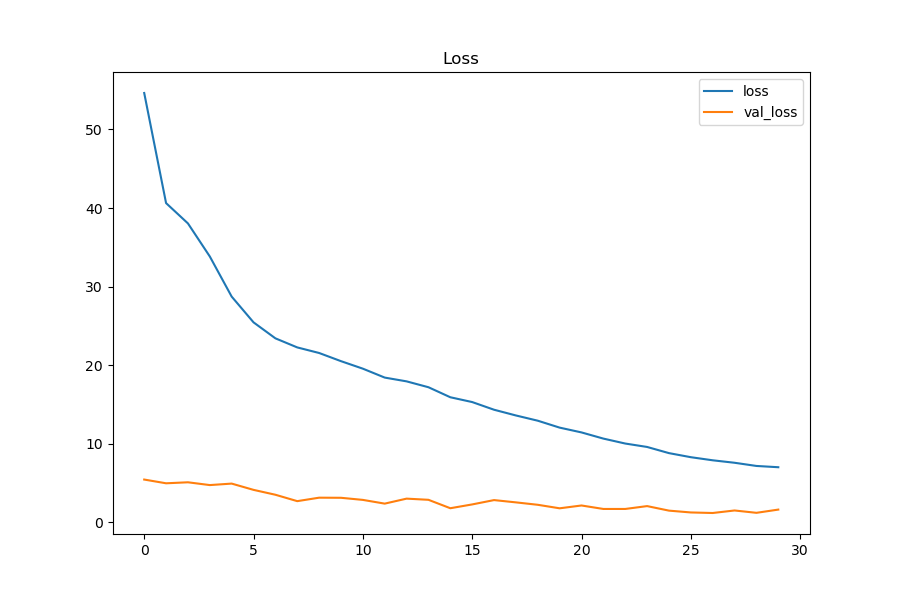

<IPython.core.display.Javascript object>


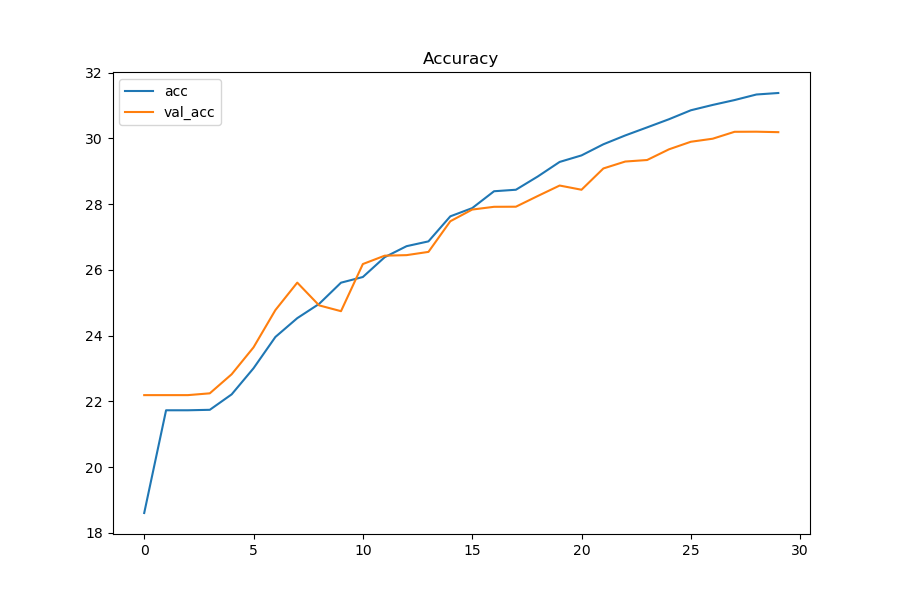

<IPython.core.display.Javascript object>


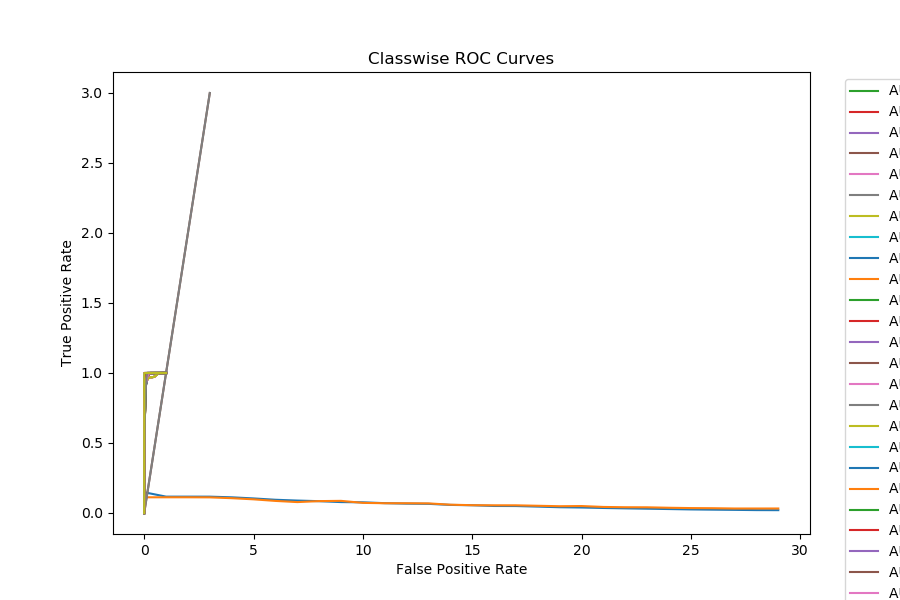

In [35]:
%reload_ext autoreload


train_dataset = CustomAudioDataset(X_train, Y_train, uids_train)
test_dataset = CustomAudioDataset(X_test, Y_test, uids_test)
val_dataset = CustomAudioDataset(X_val, Y_val, uids_val)

history, test_out, start_time, end_time = tweetynet.train_pipeline(train_dataset, val_dataset, test_dataset, 
                                                                   lr=.0015, batch_size=128,epochs=30, save_me=True,
                                                                   fine_tuning=False, finetune_path=None)

In [36]:
len(train_dataset)

3503

In [37]:
end_time - start_time

datetime.timedelta(seconds=12296, microseconds=774799)

In [38]:
test_out


uid  zero_pred  one_pred  \
0      XC26149 - Pale-breasted Thrush - Turdus leucom...  -0.532347  0.893773   
1      XC26149 - Pale-breasted Thrush - Turdus leucom...  -0.460072  0.893756   
2      XC26149 - Pale-breasted Thrush - Turdus leucom...  -0.665359  0.983592   
3      XC26149 - Pale-breasted Thrush - Turdus leucom...  -0.406605  1.095643   
4      XC26149 - Pale-breasted Thrush - Turdus leucom...  -0.495135  1.070985   
...                                                  ...        ...       ...   
11227  XC127868 - Green-backed Trogon - Trogon viridi...  -0.824675  0.316643   
11228  XC127868 - Green-backed Trogon - Trogon viridi...  -0.835373  0.317194   
11229  XC127868 - Green-backed Trogon - Trogon viridi...  -0.879156  0.220889   
11230  XC127868 - Green-backed Trogon - Trogon viridi...  -0.920712  0.102354   
11231  XC127868 - Green-backed Trogon - Trogon viridi...  -1.041330  0.238358   

       pred  label  
0         5      7  
1         5      7  
2         5      7  
3         5      7  
4         5      7  
...     ...    ...  
11227     3      6  
11228     9      6  
11229     3      6  
11230     9      6  
11231     9      6  

[140256 rows x 5 columns]

In [39]:
chunked_renamed_df.to_csv("formated_tweetynet_ground_truth.csv")

# Visualization

In [40]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [41]:
predictions = pd.DataFrame()
pred_one_hot = pd.DataFrame(columns=np.append("UID", test_dataset.unique_labels()))
species = list(np.unique(chunked_renamed_df["MANUAL ID"]))
tweetynet.model.eval()


scores_df = pd.DataFrame()
pred_df = pd.DataFrame()
label_df = pd.DataFrame()

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=0)
with torch.no_grad():
    for i, data in enumerate(test_loader):
        #ACTUALLY RUNNING MODEL
        #Run model over test data
        inputs, labels, uids = data
        inputs = inputs.reshape(inputs.shape[0], 1, inputs.shape[1], inputs.shape[2])
        inputs, labels = inputs.to(tweetynet.device), labels.to(tweetynet.device)

        output = tweetynet.model(inputs, inputs.shape[0], labels.shape[0])
        
        #Maniplute data shape
        temp_uids = []
        if tweetynet.binary:
            labels = labels.detach()
            labels = torch.tensor([[x] * output.shape[-1] for x in labels]).to(tweetynet.device)
            temp_uids = np.array([[x] * output.shape[-1] for x in uids])
        else:
            for u in uids:
                for j in range(output.shape[-1]):
                     temp_uids.append(str(j) + "_" + u)
            temp_uids = np.array(temp_uids)
        
        
        #PREPRARE DATAFRAME FOR ONE HOT ENCODING VISULIZAITONS
        #Get the predictions for each
        d = {}
        p = {}
        l = {}
        label_d = {}
        scores = []
        
        prediction = torch.argmax(output, dim=1)
        d["uid"] =  temp_uids.flatten()
        p["uid"] =  temp_uids.flatten()
        for species_index in range(output.shape[1]):
            #get scores from output
            scores = []
            preds = []
            labels_ = []
            test = output[:, species_index, :].numpy()
            for file in test:
                for slice_ in file:
                    scores.append(slice_)
                    preds.append(0)
                    labels_.append(0)
                    count += 1

            d[species[species_index]] = scores
            p[species[species_index]] = preds
            l[species[species_index]] = labels_

         #Label predictions in one hot encoding
        new_scores = pd.DataFrame(d)
        new_pred = pd.DataFrame(p)
        new_labels = pd.DataFrame(l)
       
        counter = 0
        for index, row in new_pred.iterrows():
            if (index % 144 == 0 and index != 0):
                counter += 1
            species_index = prediction[counter][index % 144]
            row[species[species_index]] = 1
            new_pred.loc[index] = row
         
        counter = 0
        for index, row in new_labels.iterrows():
            if (index % 144 == 0 and index != 0):
                counter += 1
            species_index = labels[counter][index % 144]
            row[species[species_index]] = 1
            new_labels.loc[index] = row
        
        scores_df = scores_df.append(new_scores)
        pred_df = pred_df.append(new_pred)
        label_df = label_df.append(new_labels)
        print("next", i, len(test_loader))

print('Finished Testing')
scores_df, pred_df, label_df

next 0 31
next 1 31
next 2 31
next 3 31
next 4 31
next 5 31
next 6 31
next 7 31
next 8 31
next 9 31
next 10 31
next 11 31
next 12 31
next 13 31
next 14 31
next 15 31
next 16 31
next 17 31
next 18 31
next 19 31
next 20 31
next 21 31
next 22 31
next 23 31
next 24 31
next 25 31
next 26 31
next 27 31
next 28 31
next 29 31
next 30 31
Finished Testing


(                                                    uid  Celeus grammicus  \
 0     XC14014 - Yellow-olive Flatbill - Tolmomyias s...          1.290012   
 1     XC14014 - Yellow-olive Flatbill - Tolmomyias s...          0.309907   
 2     XC14014 - Yellow-olive Flatbill - Tolmomyias s...          0.027998   
 3     XC14014 - Yellow-olive Flatbill - Tolmomyias s...          0.090320   
 4     XC14014 - Yellow-olive Flatbill - Tolmomyias s...          0.415089   
 ...                                                 ...               ...   
 2011                      9aecb6e6-3367-444d-bf85_0.wav         -1.468210   
 2012                      9aecb6e6-3367-444d-bf85_0.wav         -1.608886   
 2013                      9aecb6e6-3367-444d-bf85_0.wav         -1.154087   
 2014                      9aecb6e6-3367-444d-bf85_0.wav         -1.330653   
 2015                      9aecb6e6-3367-444d-bf85_0.wav         -0.845776   
 
       Microcerculus marginatus  Myioborus miniatus  Ramphasto

In [42]:
label_df

Celeus grammicus  Microcerculus marginatus  Myioborus miniatus  \
0                    0                         0                   0   
1                    0                         0                   0   
2                    0                         0                   0   
3                    0                         0                   0   
4                    0                         0                   0   
...                ...                       ...                 ...   
2011                 0                         0                   0   
2012                 0                         0                   0   
2013                 0                         0                   0   
2014                 0                         0                   0   
2015                 0                         0                   0   

      Ramphastos tucanus  Thraupis episcopus  Tolmomyias sulphurescens  \
0                      0                   0                         1   
1                      0                   0                         1   
2                      0                   0                         1   
3                      0                   0                         1   
4                      0                   0                         1   
...                  ...                 ...                       ...   
2011                   0                   0                         0   
2012                   0                   0                         0   
2013                   0                   0                         0   
2014                   0                   0                         0   
2015                   0                   0                         0   

      Trogon viridis  Turdus leucomelas  Xiphorhynchus guttatus  \
0                  0                  0                       0   
1                  0                  0                       0   
2                  0                  0                       0   
3                  0                  0                       0   
4                  0                  0                       0   
...              ...                ...                     ...   
2011               0                  0                       0   
2012               0                  0                       0   
2013               0                  0                       0   
2014               0                  0                       0   
2015               0                  0                       0   

      Zonotrichia capensis  no bird  
0                        0        0  
1                        0        0  
2                        0        0  
3                        0        0  
4                        0        0  
...                    ...      ...  
2011                     0        1  
2012                     0        1  
2013                     0        1  
2014                     0        1  
2015                     0        1  

[140256 rows x 11 columns]

In [43]:
scores_df

uid  Celeus grammicus  \
0     XC14014 - Yellow-olive Flatbill - Tolmomyias s...          1.290012   
1     XC14014 - Yellow-olive Flatbill - Tolmomyias s...          0.309907   
2     XC14014 - Yellow-olive Flatbill - Tolmomyias s...          0.027998   
3     XC14014 - Yellow-olive Flatbill - Tolmomyias s...          0.090320   
4     XC14014 - Yellow-olive Flatbill - Tolmomyias s...          0.415089   
...                                                 ...               ...   
2011                      9aecb6e6-3367-444d-bf85_0.wav         -1.468210   
2012                      9aecb6e6-3367-444d-bf85_0.wav         -1.608886   
2013                      9aecb6e6-3367-444d-bf85_0.wav         -1.154087   
2014                      9aecb6e6-3367-444d-bf85_0.wav         -1.330653   
2015                      9aecb6e6-3367-444d-bf85_0.wav         -0.845776   

      Microcerculus marginatus  Myioborus miniatus  Ramphastos tucanus  \
0                    -1.977170           -0.841218           -0.950634   
1                    -3.023699           -0.664496           -1.298124   
2                    -3.800411           -0.467598           -1.490862   
3                    -3.512542           -0.314550           -1.458305   
4                    -2.893322           -0.420063           -1.290959   
...                        ...                 ...                 ...   
2011                 -2.245463           -2.858629           -1.293828   
2012                 -2.316774           -2.520455           -1.687823   
2013                 -2.246815           -2.688690           -1.261926   
2014                 -1.268261           -2.434327           -1.526157   
2015                 -0.881863           -1.802484           -1.583212   

      Thraupis episcopus  Tolmomyias sulphurescens  Trogon viridis  \
0              -1.525934                  3.637211       -0.546448   
1              -1.731440                  3.756252       -0.465630   
2              -1.273205                  4.176338       -1.279888   
3              -1.145234                  4.060434       -1.552614   
4              -1.371624                  4.014163       -1.975903   
...                  ...                       ...             ...   
2011           -3.674900                 -1.357620       -2.074391   
2012           -3.254517                 -1.088622       -1.922980   
2013           -3.234976                 -1.477109       -2.080128   
2014           -3.424341                 -1.503315       -2.162741   
2015           -2.533166                 -0.842057       -1.979265   

      Turdus leucomelas  Xiphorhynchus guttatus  Zonotrichia capensis  \
0              1.907327                0.579477             -0.045964   
1              1.886773               -0.336202              1.003883   
2              2.284100                0.211890              0.850020   
3              2.176944                0.514590              0.801905   
4              1.922819                0.475999              0.503759   
...                 ...                     ...                   ...   
2011          -4.027835               -2.302594             -1.433235   
2012          -4.194953               -2.366523             -0.852672   
2013          -3.976013               -2.057315             -1.129196   
2014          -4.209496               -2.219727             -1.195807   
2015          -4.087416               -1.548434             -1.167618   

       no bird  
0    -0.790376  
1    -0.631066  
2    -1.019879  
3    -1.212337  
4    -0.976764  
...        ...  
2011  7.233087  
2012  6.782204  
2013  7.071927  
2014  6.779796  
2015  5.983458  

[140256 rows x 12 columns]

In [44]:
scores_df = scores_df.set_index("uid")

In [45]:
label_df

Celeus grammicus  Microcerculus marginatus  Myioborus miniatus  \
0                    0                         0                   0   
1                    0                         0                   0   
2                    0                         0                   0   
3                    0                         0                   0   
4                    0                         0                   0   
...                ...                       ...                 ...   
2011                 0                         0                   0   
2012                 0                         0                   0   
2013                 0                         0                   0   
2014                 0                         0                   0   
2015                 0                         0                   0   

      Ramphastos tucanus  Thraupis episcopus  Tolmomyias sulphurescens  \
0                      0                   0                         1   
1                      0                   0                         1   
2                      0                   0                         1   
3                      0                   0                         1   
4                      0                   0                         1   
...                  ...                 ...                       ...   
2011                   0                   0                         0   
2012                   0                   0                         0   
2013                   0                   0                         0   
2014                   0                   0                         0   
2015                   0                   0                         0   

      Trogon viridis  Turdus leucomelas  Xiphorhynchus guttatus  \
0                  0                  0                       0   
1                  0                  0                       0   
2                  0                  0                       0   
3                  0                  0                       0   
4                  0                  0                       0   
...              ...                ...                     ...   
2011               0                  0                       0   
2012               0                  0                       0   
2013               0                  0                       0   
2014               0                  0                       0   
2015               0                  0                       0   

      Zonotrichia capensis  no bird  
0                        0        0  
1                        0        0  
2                        0        0  
3                        0        0  
4                        0        0  
...                    ...      ...  
2011                     0        1  
2012                     0        1  
2013                     0        1  
2014                     0        1  
2015                     0        1  

[140256 rows x 11 columns]

In [46]:
scores_df

Celeus grammicus  \
uid                                                                    
XC14014 - Yellow-olive Flatbill - Tolmomyias su...          1.290012   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...          0.309907   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...          0.027998   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...          0.090320   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...          0.415089   
...                                                              ...   
9aecb6e6-3367-444d-bf85_0.wav                              -1.468210   
9aecb6e6-3367-444d-bf85_0.wav                              -1.608886   
9aecb6e6-3367-444d-bf85_0.wav                              -1.154087   
9aecb6e6-3367-444d-bf85_0.wav                              -1.330653   
9aecb6e6-3367-444d-bf85_0.wav                              -0.845776   

                                                    Microcerculus marginatus  \
uid                                                                            
XC14014 - Yellow-olive Flatbill - Tolmomyias su...                 -1.977170   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...                 -3.023699   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...                 -3.800411   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...                 -3.512542   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...                 -2.893322   
...                                                                      ...   
9aecb6e6-3367-444d-bf85_0.wav                                      -2.245463   
9aecb6e6-3367-444d-bf85_0.wav                                      -2.316774   
9aecb6e6-3367-444d-bf85_0.wav                                      -2.246815   
9aecb6e6-3367-444d-bf85_0.wav                                      -1.268261   
9aecb6e6-3367-444d-bf85_0.wav                                      -0.881863   

                                                    Myioborus miniatus  \
uid                                                                      
XC14014 - Yellow-olive Flatbill - Tolmomyias su...           -0.841218   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...           -0.664496   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...           -0.467598   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...           -0.314550   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...           -0.420063   
...                                                                ...   
9aecb6e6-3367-444d-bf85_0.wav                                -2.858629   
9aecb6e6-3367-444d-bf85_0.wav                                -2.520455   
9aecb6e6-3367-444d-bf85_0.wav                                -2.688690   
9aecb6e6-3367-444d-bf85_0.wav                                -2.434327   
9aecb6e6-3367-444d-bf85_0.wav                                -1.802484   

                                                    Ramphastos tucanus  \
uid                                                                      
XC14014 - Yellow-olive Flatbill - Tolmomyias su...           -0.950634   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...           -1.298124   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...           -1.490862   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...           -1.458305   
XC14014 - Yellow-olive Flatbill - Tolmomyias su...           -1.290959   
...                                                                ...   
9aecb6e6-3367-444d-bf85_0.wav                                -1.293828   
9aecb6e6-3367-444d-bf85_0.wav                                -1.687823   
9aecb6e6-3367-444d-bf85_0.wav                                -1.261926   
9aecb6e6-3367-444d-bf85_0.wav                                -1.526157   
9aecb6e6-3367-444d-bf85_0.wav                                -1.583212   

                                                    Thraupis episcopus  \
uid                                                                      


In [47]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
print(classification_report(label_df, scores_df))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [66]:
%matplotlib 
import matplotlib.pyplot as plt

Using matplotlib backend: nbAgg


In [72]:
import matplotlib
print("Using:",matplotlib.get_backend())
gui_env = ['GTKAgg','Qt4Agg','WXAgg']
for gui in gui_env:
    try:
        print("testing", gui)
        matplotlib.use(gui,warn=False, force=True)
        from matplotlib import pyplot as plt
        break
    except:
        continue
print("Using:",matplotlib.get_backend())


Using: TkAgg
testing GTKAgg
Using: GTKAgg


<IPython.core.display.Javascript object>


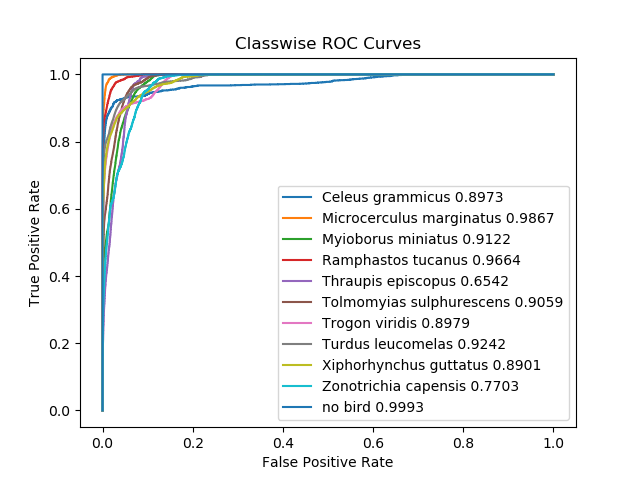

In [76]:
for species in label_df.columns:
    fpr, tpr, thresh = roc_curve(label_df[species],  scores_df[species])
    auc = roc_auc_score(label_df[species],  pred_df[species])
    plt.plot(fpr,tpr,label=species + " "+str(round(auc, 4)))

plt.title('Classwise ROC Curves')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()#bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()

In [54]:
label_df.columns

Index(['Celeus grammicus', 'Microcerculus marginatus', 'Myioborus miniatus',
       'Ramphastos tucanus', 'Thraupis episcopus', 'Tolmomyias sulphurescens',
       'Trogon viridis', 'Turdus leucomelas', 'Xiphorhynchus guttatus',
       'Zonotrichia capensis', 'no bird'],
      dtype='object')

In [62]:
plt.plot([0,1,2,3],[0,1,2,3])
plt.show()

In [63]:
plt.get_backend()

'nbAgg'